# Parsing the entire h5ad file

## 1. Read predictions from all sources, and merge them into the AnnData object

In [1]:
import plotly.graph_objects as go, plotly.express as px
import scanpy as sc, pandas as pd, numpy as np


ANNDATA_FOLDER = 'datasets'
QUERY_DATASET_NAME = 'LCA'

# "LCA.h5ad" file is pre-annotated
predictions_adata = sc.read_h5ad(f'{ANNDATA_FOLDER}/{QUERY_DATASET_NAME}/{QUERY_DATASET_NAME}.h5ad')
# predictions_adata.obs = pd.DataFrame(predictions_adata.obs.rename({'cell_ontology_type':'popv_preds', 'cell_type':'popv_preds'}, axis=1)['popv_preds'])


# Get rid of the individual cell-level preds from PopV. Keep only majority_voting in obs dataframe
popv_lung_preds = pd.read_csv(f'{ANNDATA_FOLDER}/{QUERY_DATASET_NAME}/popv_preds.csv')
predictions_adata.obs['popv_preds'] = popv_lung_preds['popv_majority_vote_prediction'].tolist()
predictions_adata.obs['popv_scores'] = popv_lung_preds['popv_prediction_score'].tolist()


# Get rid of the individual cell-level preds from CellTypist. Keep only majority_voting in obs dataframe
celltypist_lung_preds = pd.read_csv(f'{ANNDATA_FOLDER}/{QUERY_DATASET_NAME}/celltypist_preds.csv')
predictions_adata.obs['celltypist_preds'] = celltypist_lung_preds['majority_voting'].tolist()
predictions_adata.obs['celltypist_scores'] = celltypist_lung_preds['conf_score'].tolist()


# Merge in Azimuth predictions in obs dataframe
azimuth_lung_preds = pd.read_csv(f'{ANNDATA_FOLDER}/{QUERY_DATASET_NAME}/azimuth_preds.tsv', sep=' ')
predictions_adata.obs['azimuth_preds'] = azimuth_lung_preds['predicted.ann_finest_level'].tolist()
predictions_adata.obs['azimuth_scores'] = azimuth_lung_preds['predicted.ann_finest_level.score'].tolist()




# Create new df with all unique CT-labels across 3 sources
all_cts = list(predictions_adata.obs['azimuth_preds'].to_numpy()) + \
            list(predictions_adata.obs['celltypist_preds'].to_numpy()) + \
                list(predictions_adata.obs['popv_preds'].to_numpy())
unique_cts = sorted([ct.lower().replace('φ','ï†') for ct in set(all_cts)])
unique_cts[:10]

['adventitial cell',
 'adventitial fibroblasts',
 'alveolar fibroblasts',
 'alveolar macrophages',
 'alveolar mï† ccl3+',
 'alveolar mï† proliferating',
 'at1',
 'at2',
 'at2 proliferating',
 'b cell']

In [2]:
# 1 hour to export the CxG into CSV so that we can explore FR-Match
# predictions_adata.to_df().to_csv(f'{ANNDATA_FOLDER}/{QUERY_DATASET_NAME}/SingleCellExperiment_src_files/cell_by_gene_expression.csv', index=False)

### 2. Create an aggregated df suggested by Katy

| unique_Cts | CT-ID | # Azimuth | # CellTypist | # PopV |
|---|---|---|---|---|

Extending this table to include Azimuth's HLCAv2 known Marker-Genes so that we can create stacked Violin-Plot.

Similarly, we can use NSForest to explore Marker-Genes so that we can create similar stacked Violin-Plots.

Final table structure:
| unique_Cts | CT-ID | # Azimuth | # CellTypist | # PopV | canonical-BGs from Azimuth | canonical-BGs from ASCTB | NSForest-BGs for Azimuth preds | NSForest-BGs for CellTypist preds | NSForest-BGs for PopV preds |
|---|---|---|---|---|---|---|---|---|---|

>

> 

>

> Future scope: Compare inter-cluster similarities by using `FR-Match`.

In [11]:
import plotly.graph_objects as go
import random


# Create a dataframe to hold information on markers pulled from Azimuth/ASCTB and NSForest.
# Later, we'll merge our crosswalk of Azimuth/CellTypist/PopV to translate labels -> ASCTB naming conventions.
agg_crosswalk_markers_df = pd.DataFrame(unique_cts, columns=['unique_cts'])


# Get aggregate count of cells per CellType label in predictions dataframe
for source in ['azimuth', 'popv', 'celltypist']:
    preds_column = f'{source}_preds'
    curr_agg_df = pd.DataFrame(predictions_adata.obs.groupby(by=[preds_column])[preds_column].count())
    curr_agg_df.columns = [f'{source}_count']
    curr_agg_df = curr_agg_df.reset_index()
    curr_agg_df[preds_column] = curr_agg_df[preds_column].str.lower().replace('φ','ï†')
    agg_crosswalk_markers_df = pd.merge(agg_crosswalk_markers_df, curr_agg_df, how='left', left_on='unique_cts', right_on=preds_column).drop([preds_column], axis=1)


agg_crosswalk_markers_df

unique_cts  azimuth_count  popv_count  \
0                         adventitial cell            NaN       417.0   
1                  adventitial fibroblasts          454.0         NaN   
2                     alveolar fibroblasts         1942.0         NaN   
3                     alveolar macrophages         9565.0         NaN   
4                       alveolar mï† ccl3+            NaN         NaN   
..                                     ...            ...         ...   
82                                    tuft            1.0         NaN   
83                       type i pneumocyte            NaN      1521.0   
84                      type ii pneumocyte            NaN      5125.0   
85  vascular associated smooth muscle cell            NaN       571.0   
86                   vein endothelial cell            NaN      1240.0   

    celltypist_count  
0                NaN  
1              592.0  
2             1847.0  
3             9004.0  
4                NaN  
..               ...  
82               NaN  
83               NaN  
84               NaN  
85               NaN  
86               NaN  

[87 rows x 4 columns]

## 3. Run NS-Forest over predicted labels to identify algorithmic marker-genes

We can then compare the marker genes that were:

> Reported by Azimuth

> Generated through a discriminatory algorithm for 1-vs-all classification (NSForest)

#### We'll maintain 2 JSON structures for:

1. Canonical markers derived from known sources (ASCTB / Azimuth)
2. Algorithmically derived markers (using NS-Forest).

The structure in general will be:

```python
{
    'Azimuth' : {
        'CellType annotation A' : [list of markers],
        'CellType annotation B' : [list of markers],
        ...
    },
    'CellTypist' : {
        'CellType annotation X' : [list of markers],
        'CellType annotation Y' : [list of markers],
        ...
    },
    
    ...
}
```

In [12]:
CANONICAL_MARKERS = {}
ALGORITHMICALLY_DERIVED_MARKERS = {}

# 4. Fetch ASCT+B marker genes

In [13]:
import base64, json, sys, re, os, pandas as pd, json, http.client
from pprint import pprint
from requests import get



def get_ccf_reporter_sheet_config(verbose=False):
    """Accesses the Github repo for CCF-reporter, pulls the sheet-config at below URL.
    `https://github.com/hubmapconsortium/ccf-asct-reporter/blob/main/projects/v2/src/assets/sheet-config.json`
    
    This sheet contains links for all ASCT+B organs --> dataset URL.
    Args:
        verbose (bool, optional): Flag to indicate logging in verbose mode. Defaults to False.
    
    Return:
        list(dict): Python version of the `sheet_config.json` file.
    """
    USER = 'hubmapconsortium'
    REPOSITORY_NAME = 'ccf-asct-reporter'
    FILE_PATH = '/projects/v2/src/assets/sheet-config.json'
    sheet_config = None
    response = get(url=f'https://api.github.com/repos/{USER}/{REPOSITORY_NAME}/contents/{FILE_PATH}')
    if response.status_code == 200:
        json_response = response.json()
        decoded_content = base64.b64decode(json_response['content']) # Github returns response in b64 encoding
        json_string = decoded_content.decode('utf-8')
        sheet_config = json.loads(json_string)
    else:
        print(f'Error {response.status_code}! Something went wrong while trying to read the CCF-Reporter Github repo sheet-config file...')
    if verbose:  print(f'sheet_config = \n{sheet_config}')
    return sheet_config



def get_asctb_data_url(asctb_organ='Lung', asctb_organ_version='v1.1', verbose=False):
    """Reads the sheet-config from the CCF-reporter Github repo, and parses it to fetch the dataset-link for the specific organ and version.
    Args:
        asctb_organ (str, optional): Defaults to 'Lung'.
        asctb_organ_version (str, optional): Defaults to 'v1.1'.
        verbose (bool, optional): Flag to indicate logging in verbose mode. Defaults to False.
    Returns:
        str: `URL` for the specific ASCT+B organ and version.
        str: `sheetId` for the specific ASCT+B organ and version.
        str: `gid` for the required ASCT+B organ and version.
    """
    GOOGLE_SHEETS_BASE_URL = 'https://docs.google.com/spreadsheets/d/'
    SHEET_CONFIG = get_ccf_reporter_sheet_config(verbose=verbose)
    if not SHEET_CONFIG:
        sys.exit('Couldnt access the CCF-Reporter Github!')

    for asctb_dataset in SHEET_CONFIG:
        if asctb_dataset['name'].lower() == asctb_organ.lower():
            if verbose:  pprint(asctb_dataset)
            for version_metadata in asctb_dataset['version']:
                if version_metadata['viewValue'] == asctb_organ_version:
                    version_name = version_metadata['value']
                    google_sheets_url = GOOGLE_SHEETS_BASE_URL + version_metadata['sheetId']
                    if verbose:  print(version_name, google_sheets_url)
                    return google_sheets_url, version_metadata['sheetId'], version_metadata['gid']
    return None




def get_asctb_data(asctb_organ='Lung', asctb_organ_version='v1.2', verbose=False):
    """Fetches the URL for the specific ASCTB organ version, and reads the entire Google sheet data.
    Uses the CCF-reporter API documentation available here: mmpyikxkcp.us-east-2.awsapprunner.com

    Args:
        asctb_organ (str, optional): Defaults to 'Lung'.
        asctb_organ_version (str, optional): Defaults to 'v1.2'.
        verbose (bool, optional): Flag to indicate logging in verbose mode. Defaults to False.

    Returns:
        dict: Json response containing rows of the ASCTB organ version dataset.
    """
    _, sheet_id, gid = get_asctb_data_url(asctb_organ=asctb_organ, asctb_organ_version=asctb_organ_version, verbose=verbose)
    conn = http.client.HTTPSConnection("mmpyikxkcp.us-east-2.awsapprunner.com")
    headers = { 'Content-Type': "application/json" }
    conn.request('GET', f'/v2/{sheet_id}/{gid}/', headers=headers)
    res = conn.getresponse()
    data = res.read().decode("utf-8")
    response = json.loads(data)
    return response


def parse_asctb_ct_vs_bg(response, verbose=False):
    """Parse each row of the ASCTB organ version json data and return a dictionary for:
        
        `{ Cell-Type name : Set of canonical biomarkers reported by ASCT+B authors }`

    Args:
        response (dict): Json response containing rows of the ASCTB organ version dataset.
        verbose (bool, optional): Flag to indicate logging in verbose mode. Defaults to False.

    Returns:
        dict: Dictionary containing `{ Cell-Type name : Set of canonical biomarkers reported by ASCT+B authors }`
    """
    hmap = dict()
    for single_row in response['data']:
        biomarker_genes = set([biomarker['name'] for biomarker in single_row['biomarkers']]) # 'biomarker_genes'
        for row in single_row['cell_types']:
            ct_name = row['name'].lower().replace('φ','ï†')
            if ct_name not in hmap:
                hmap[ct_name] = []
            hmap[ct_name].extend(list(biomarker_genes))
    for ct, bgs in hmap.items():
        hmap[ct] = list(set(bgs))
    if verbose:  pprint(hmap)
    return hmap



def fetch_and_parse_crosswalk_table(crosswalk_filename='Azimuth_CellTypist_PopV_Lung_ASCTB_Crosswalks.csv', raw_labels_colname='raw_input_column', asctb_crosswalk_colname='translation_column', tgt_crosswalk_colname='asctb_equivalent', verbose=False):
    """Processes the final-crosswalk data containing SME feedback for translating raw-labels into ASCTB naming convention.

    Args:
        crosswalk_filename (str, optional): Defaults to 'Azimuth_CellTypist_PopV_Lung_ASCTB_Crosswalks.csv'.
        raw_labels_colname (str, optional): Defaults to 'raw_input_column'.
        asctb_crosswalk_colname (str, optional): Defaults to 'translation_column'.
        tgt_crosswalk_colname (str, optional): Defaults to 'asctb_equivalent'.
        verbose (bool, optional): Flag to indicate logging in verbose mode. Defaults to False.

    Returns:
        pd.DataFrame: Contains the final-crosswalk information.
    """
    # Merge the aggregated data with the translations file created using our ASCTB-Mapper package with finalized SME feedback
    crosswalk_df = pd.read_csv(crosswalk_filename)

    crosswalk_df['source'] = crosswalk_df['source'].replace('Azimuth-HLCAv2', 'azimuth').replace('PopV-Lung', 'popv').replace('CellTypist-Lung', 'celltypist')

    crosswalk_df[raw_labels_colname] = crosswalk_df[raw_labels_colname].str.lower().replace('φ','ï†')

    crosswalk_df[tgt_crosswalk_colname] = crosswalk_df[asctb_crosswalk_colname].replace('?', np.nan)
    crosswalk_df.loc[crosswalk_df[tgt_crosswalk_colname].isna(), tgt_crosswalk_colname] = crosswalk_df.loc[crosswalk_df[tgt_crosswalk_colname].isna(), 'best_matched_asctb_label']
    crosswalk_df[tgt_crosswalk_colname] = crosswalk_df[tgt_crosswalk_colname].str.lower().replace('φ','ï†')
    return crosswalk_df



def get_crosswalk_translation_hmap(crosswalk_df):
    """Create a hashmap of Gloria's crosswalk for cell-type labels from Azimuth/CellTypist/PopV -> ASCTB naming conventions.

    Args:
        crosswalk_df (pd.DataFrame): DataFrame containing final crosswalk information. Essential columns: `[unique_cts, asctb_equivalent]`.
    """
    translation_hmap = dict(
        zip(
            crosswalk_df['unique_cts'], crosswalk_df['asctb_equivalent']
        )
    )
    return translation_hmap




# Read and preprocess the Crosswalk table with SME Feedback to translate annotations -> ASCTB convention
crosswalk_df = fetch_and_parse_crosswalk_table(
    crosswalk_filename='ASCTB_Mapper/Azimuth_CellTypist_PopV_Lung_ASCTB_Crosswalks.csv',
    raw_labels_column='raw_input_label',
    asctb_crosswalk_column='Glorias_recco_for_ASCTB_Crosswalk',
    tgt_crosswalk_colname='asctb_equivalent',
    verbose=False
)


# Merge the crosswalk into the existing aggregate view of unique CT-labels, counts in the 3 sources and markers from various sources 
agg_crosswalk_markers_df = pd.merge(agg_crosswalk_markers_df, crosswalk_df[['raw_input_label', 'asctb_equivalent']], how='left', left_on='unique_cts', right_on='raw_input_label')
agg_crosswalk_markers_df = agg_crosswalk_markers_df.drop(columns=['raw_input_label']).drop_duplicates(subset=['unique_cts']).fillna(0).reset_index(drop=True)

translation_hmap = get_crosswalk_translation_hmap(agg_crosswalk_markers_df)



# Fetch ASCTB Lung data and merge it into our Aggregated dataframe containing counts, and crosswalk information.
response = get_asctb_data(asctb_organ='Lung', asctb_organ_version='v1.2', verbose=False)
raw_asctb_markers_json = parse_asctb_ct_vs_bg(response, verbose=False)

# Parse the json into a usable dataframe of ASCTB CT vs Markers
asctb_markers_df = pd.DataFrame([raw_asctb_markers_json]).T.reset_index()
asctb_markers_df.columns = ['asctb_label', 'asctb_markers']



if 'asctb_markers' not in agg_crosswalk_markers_df.columns:
    agg_crosswalk_markers_df = pd.merge(
        left=agg_crosswalk_markers_df,
        right=asctb_markers_df,
        left_on='asctb_equivalent',
        right_on='asctb_label'
    )
    agg_crosswalk_markers_df = agg_crosswalk_markers_df.drop('asctb_label', axis=1)



# store cluster-marker information in a dictionary
CANONICAL_MARKERS['asctb'] = dict(
    zip(
        agg_crosswalk_markers_df.loc[~agg_crosswalk_markers_df['asctb_markers'].isna(), 'unique_cts'],
        agg_crosswalk_markers_df.loc[~agg_crosswalk_markers_df['asctb_markers'].isna(), 'asctb_markers'],
    )
)

agg_crosswalk_markers_df.head()

unique_cts  azimuth_count  popv_count  celltypist_count  \
0      adventitial cell            0.0       417.0               0.0   
1            suprabasal          580.0         0.0             860.0   
2  alveolar fibroblasts         1942.0         0.0            1847.0   
3  alveolar macrophages         9565.0         0.0            9004.0   
4    alveolar mï† ccl3+            0.0         0.0               0.0   

             asctb_equivalent                                    asctb_markers  
0             suprabasal cell                [NOTCH3, KRT19, NGFR, TP63, KRT5]  
1             suprabasal cell                [NOTCH3, KRT19, NGFR, TP63, KRT5]  
2  alveolar type 1 fibroblast                     [PCDH15, WNT2, TCF21, PLIN2]  
3         alveolar macrophage   [CD68, MARCO, CD11c, CD45, MRC1, FABP4, CD163]  
4   alveolar macrophage ccl3+  [PTPRC/CD45, CD68, CD45, SIGLEC1, CCL3, CD206 ]

# Next, visualize the markers identified using Scanpy Violin-Plot

## a. Let's Focus on Azimuth first:

### 1. Azimuth's canonical marker-genes pulled directly from Rahul's website

In [14]:
sc.pp.normalize_total(predictions_adata, target_sum = 1e4)
sc.pp.log1p(predictions_adata)

In [15]:
from requests import get
import base64, json

def get_specific_azimuth_marker_genes(filename='hlca_level1.csv', verbose=False):
    """Accesses the Github repo for Azimuth, and pulls the lung-information from specific URLs.
    
    Args:
        verbose (bool, optional): Flag to indicate logging in verbose mode. Defaults to False.
    
    Return:
        pd.DataFrame
    """
    USER = 'satijalab'
    REPOSITORY_NAME = 'azimuth_website'
    FILE_PATH = f'/static/csv/{filename}'
    URL = f'https://raw.githubusercontent.com/{USER}/{REPOSITORY_NAME}/master/{FILE_PATH}'
    df = pd.read_csv(URL, index_col=0)
    if verbose:  print(f'data = \n{df}')
    return df




def get_all_azimuth_marker_genes(organ='lung', verbose=False):
    """Accesses the Github repo for Azimuth, and pulls the lung-information from below URLs.
    `https://github.com/satijalab/azimuth_website/blob/master/static/csv/hlca_level1.csv`,
    `https://github.com/satijalab/azimuth_website/blob/master/static/csv/hlca_level2.csv`,
    `https://github.com/satijalab/azimuth_website/blob/master/static/csv/hlca_level3.csv`,
    `https://github.com/satijalab/azimuth_website/blob/master/static/csv/hlca_level4.csv`,
    `https://github.com/satijalab/azimuth_website/blob/master/static/csv/hlca_level5.csv`,
    `https://github.com/satijalab/azimuth_website/blob/master/static/csv/hlca_finest_level.csv`

    There are also some naming-convention issues to be fixed:
        The Azimuth HLCA_finest marker-genes file, contains "non classical monocytes" and "transitional club at2" while the 
        actual algorithm predictions are "non-classical monocytes" and "transitional club-at2" respectively.

    Args:
        organ (str, optional): Defaults to 'lung'.
        verbose (bool, optional): Flag to indicate logging in verbose mode. Defaults to False.

    Returns:
        pd.DataFrame: Columns are [`'Label'`, `'Markers'`].
    """
    azimuth_marker_genes_df = pd.DataFrame()
    if organ=='lung':
        FILENAMES = ['hlca_level1', 'hlca_level2', 'hlca_level3', 'hlca_level4', 'hlca_level5', 'hlca_finest_level']
    for filename in FILENAMES:
        if verbose:  print(f'Trying to access {filename} in Azimuth Github-Repo.')
        curr_marker_genes_df = get_specific_azimuth_marker_genes(filename=f'{filename}.csv', verbose=verbose)
        curr_marker_genes_df = curr_marker_genes_df[['Label','Markers']]
        azimuth_marker_genes_df = pd.concat([azimuth_marker_genes_df, curr_marker_genes_df]).drop_duplicates(subset=['Label'])
    azimuth_marker_genes_df.columns = ['unique_cts', 'azimuth_markers']
    azimuth_marker_genes_df['unique_cts'] = azimuth_marker_genes_df['unique_cts'].str.lower().replace('φ','ï†')
    
    # Fixing some clearly naming-convention issues.
    azimuth_marker_genes_df.loc[azimuth_marker_genes_df['unique_cts']=='non classical monocytes' , 'unique_cts'] = 'non-classical monocytes'
    azimuth_marker_genes_df.loc[azimuth_marker_genes_df['unique_cts']=='transitional club at2' , 'unique_cts'] = 'transitional club-at2'
    azimuth_marker_genes_df = azimuth_marker_genes_df.reset_index(drop=True)
    return azimuth_marker_genes_df



def filter_valid_set_genes(input_genes, genes_available_in_anndata, verbose=False):
    """Keep only those marker-genes that exist within the input AnnData.
    After this standardization, we can utilize the scanpy.stacked_violin_plot() function.

    Args:
        input_genes (str): The data fetched from Azimuth's Github for Marker-genes, contains [`marker-genes`] column as a string.
        genes_available_in_anndata (iterable): You can access the unique gene-names present within the input AnnData as `predictions_adata.var_names`.
        verbose (bool, optional): Flag to indicate logging in verbose mode. Defaults to False.

    Returns:
        list: List of valid marker-genes that exist within the input-AnnData.
    """
    input_genes = [gene.strip() for gene in input_genes.split(',')]
    valid_genes = set(predictions_adata.var_names) & set(input_genes)
    valid_genes = list(valid_genes)
    if verbose:  print(valid_genes)
    return valid_genes



azimuth_marker_genes_df = get_all_azimuth_marker_genes(organ='lung', verbose=False)
azimuth_marker_genes_df['azimuth_markers'] = azimuth_marker_genes_df['azimuth_markers'].apply(
    filter_valid_set_genes, 
    genes_available_in_anndata=set(predictions_adata.var_names),
    verbose=False
)


agg_crosswalk_markers_df = pd.merge(agg_crosswalk_markers_df, azimuth_marker_genes_df, how='left', on='unique_cts').drop_duplicates(subset=['unique_cts'])
agg_crosswalk_markers_df.head()

unique_cts  azimuth_count  popv_count  celltypist_count  \
0      adventitial cell            0.0       417.0               0.0   
1            suprabasal          580.0         0.0             860.0   
2  alveolar fibroblasts         1942.0         0.0            1847.0   
3  alveolar macrophages         9565.0         0.0            9004.0   
4    alveolar mï† ccl3+            0.0         0.0               0.0   

             asctb_equivalent  \
0             suprabasal cell   
1             suprabasal cell   
2  alveolar type 1 fibroblast   
3         alveolar macrophage   
4   alveolar macrophage ccl3+   

                                     asctb_markers  \
0                [NOTCH3, KRT19, NGFR, TP63, KRT5]   
1                [NOTCH3, KRT19, NGFR, TP63, KRT5]   
2                     [PCDH15, WNT2, TCF21, PLIN2]   
3   [CD68, MARCO, CD11c, CD45, MRC1, FABP4, CD163]   
4  [PTPRC/CD45, CD68, CD45, SIGLEC1, CCL3, CD206 ]   

                                     azimuth_markers  
0                                                NaN  
1  [TACSTD2, PRDX2, SFN, KRT19, SERPINB4, KLK11, ...  
2  [COL6A1, LUM, C1R, COL1A2, A2M, GPX3, MFAP4, A...  
3  [LAPTM5, C1QC, HLA-DPA1, FCER1G, ACP5, COTL1, ...  
4                                                NaN

         Falling back to preprocessing with `sc.pp.pca` and default params.
categories: AT1, AT2, AT2 proliferating, etc.
var_group_labels: suprabasal, alveolar fibroblasts, alveolar macrophages, etc.


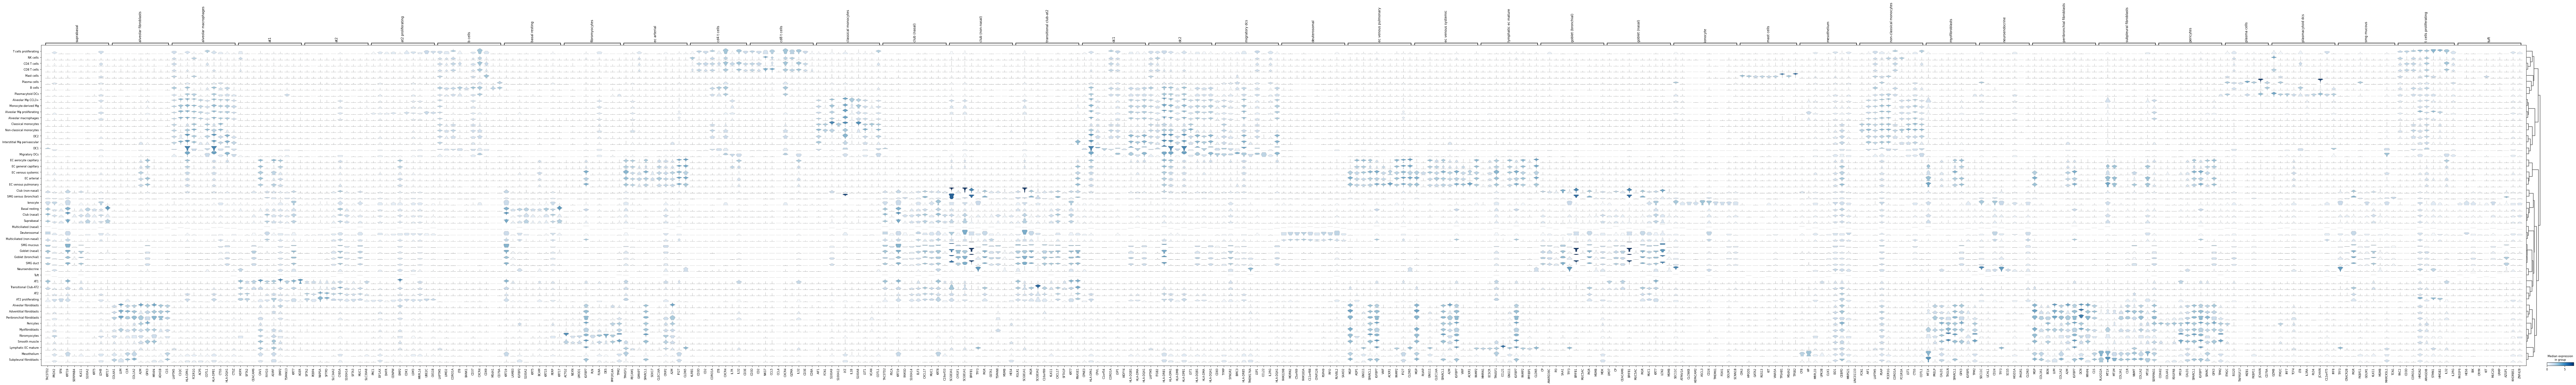

In [16]:
# store cluster-marker information in a dictionary
CANONICAL_MARKERS['azimuth'] = dict(
    zip(
        agg_crosswalk_markers_df.loc[~agg_crosswalk_markers_df['azimuth_markers'].isna(), 'unique_cts'],
        agg_crosswalk_markers_df.loc[~agg_crosswalk_markers_df['azimuth_markers'].isna(), 'azimuth_markers'],
    )
)

sc.pl.stacked_violin(
    predictions_adata, 
    var_names=CANONICAL_MARKERS['azimuth'], 
    groupby='azimuth_preds', 
    dendrogram=True, 
    use_raw=False
)

categories: AT1, AT2, AT2 proliferating, etc.
var_group_labels: suprabasal, alveolar fibroblasts, alveolar macrophages, etc.


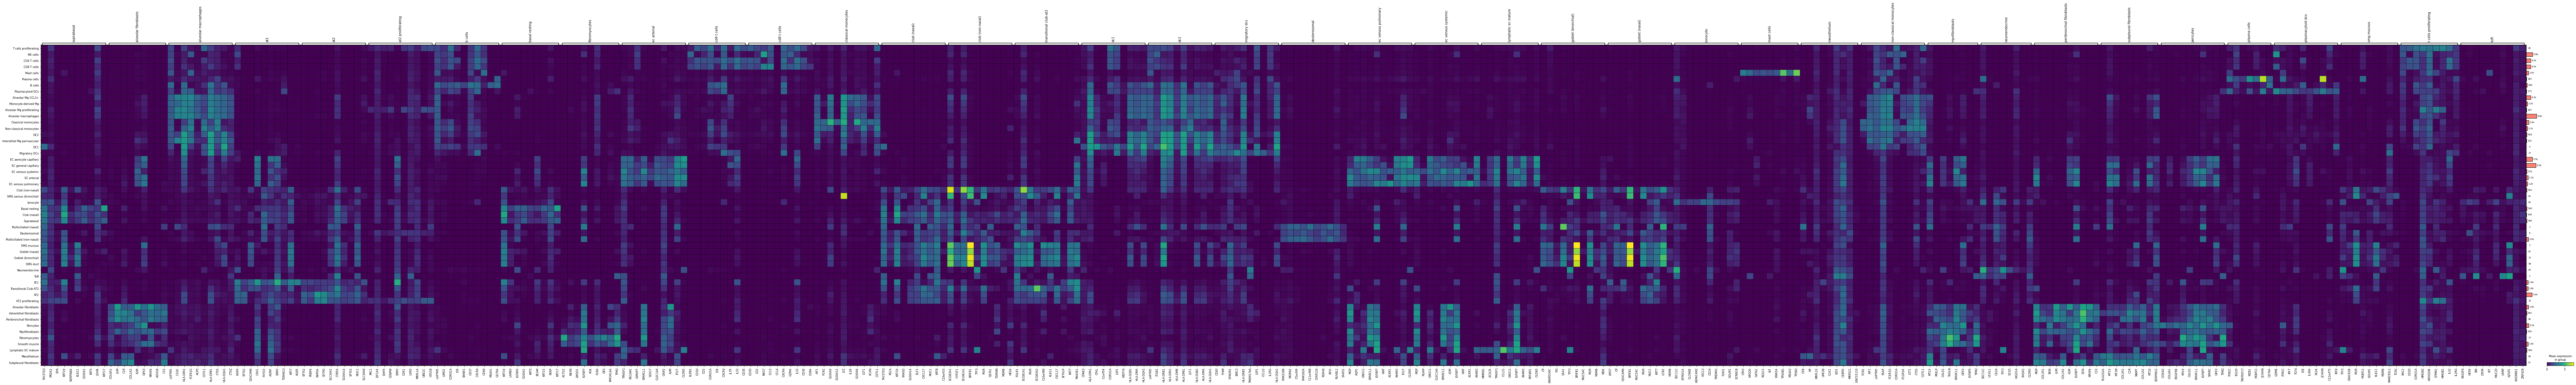

In [17]:
fig = sc.pl.matrixplot(
    predictions_adata, 
    var_names=CANONICAL_MARKERS['azimuth'],
    groupby='azimuth_preds',
    dendrogram=True,
    return_fig=True)
fig.add_totals().style(edge_color='black', edge_lw=0.5)
fig.show()

### 2. NSForest's computed marker-genes for Azimuth's HLCA-Finest predictions

In [18]:
from ns_forest.NSForest_v3dot9_1 import NSForest
from ast import literal_eval
import os

# Which column of CT-annotations do you want to analyze?
ANNOTATION_SOURCE_NAME = 'azimuth'
ANNOTATION_COLUMN_NAME = f'{ANNOTATION_SOURCE_NAME}_preds'

ns_forest_markers_filename = f'{ANNDATA_FOLDER}/{QUERY_DATASET_NAME}/NSForest_{ANNOTATION_SOURCE_NAME}_markers.csv'
print(f'Checking if NS-Forest has already been executed...')
try:
    ns_forest_markers_df = pd.read_csv(ns_forest_markers_filename)
    if ns_forest_markers_df['NSForest_markers'].dtype == 'object':
        ns_forest_markers_df.loc[:, 'NSForest_markers'] = [literal_eval(s) for s in ns_forest_markers_df['NSForest_markers'].values]
    print(f'Found pre-computed NS-Forest markers at {ns_forest_markers_filename}...')
except Exception as e:
    print(f'Something went wrong while trying to read {ns_forest_markers_filename}. Are you sure it exists? {e}')
    print(f'Running NSForest over entire AnnData containing {predictions_adata.obs[ANNOTATION_COLUMN_NAME].nunique()} labels...')
    ns_forest_markers_df = NSForest( 
        adata=predictions_adata,  cluster_header=ANNOTATION_COLUMN_NAME,
        # n_trees = 10, n_genes_eval = 10,  cluster_list = ["AT2"]
    )
    ns_forest_markers_df.to_csv(ns_forest_markers_filename, index=False)
    
    
ns_forest_markers_df.head()

Checking if NS-Forest has already been executed...
Found pre-computed NS-Forest markers at Datasets/LCA/NSForest_azimuth_markers.csv...


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


clusterName   f_score       PPV     TN   FP    FN    TP  \
0                      AT1  0.842184  0.919384  73372   89   595  1015   
1                      AT2  0.953690  0.977507  69613  107   701  4650   
2        AT2 proliferating  0.932203  1.000000  75056    0     4    11   
3  Adventitial fibroblasts  0.838926  0.965251  74608    9   204   250   
4        Alveolar Mφ CCL3+  0.755748  0.782766  70065  779  1420  2807   

   marker_count   NSForest_markers  \
0             1             [AGER]   
1             2       [PGC, NAPSA]   
2             3  [PGC, TK1, KIF23]   
3             2      [SFRP2, PI16]   
4             2     [CXCL5, TNIP3]   

                                        binary_genes  
0  ['AGER', 'SCEL', 'TNNC1', 'RTKN2', 'UPK3B', 'C...  
1  ['ABCA3', 'PGC', 'LRRK2', 'PLA2G1B', 'CLDN18',...  
2  ['YBX2', 'PEG10', 'PGC', 'TK1', 'KIF23', 'NAPS...  
3  ['SFRP2', 'MFAP5', 'PI16', 'SCARA5', 'SFRP4', ...  
4  ['CXCL5', 'TNFAIP6', 'IL1B', 'ITGB8', 'LILRA4'...

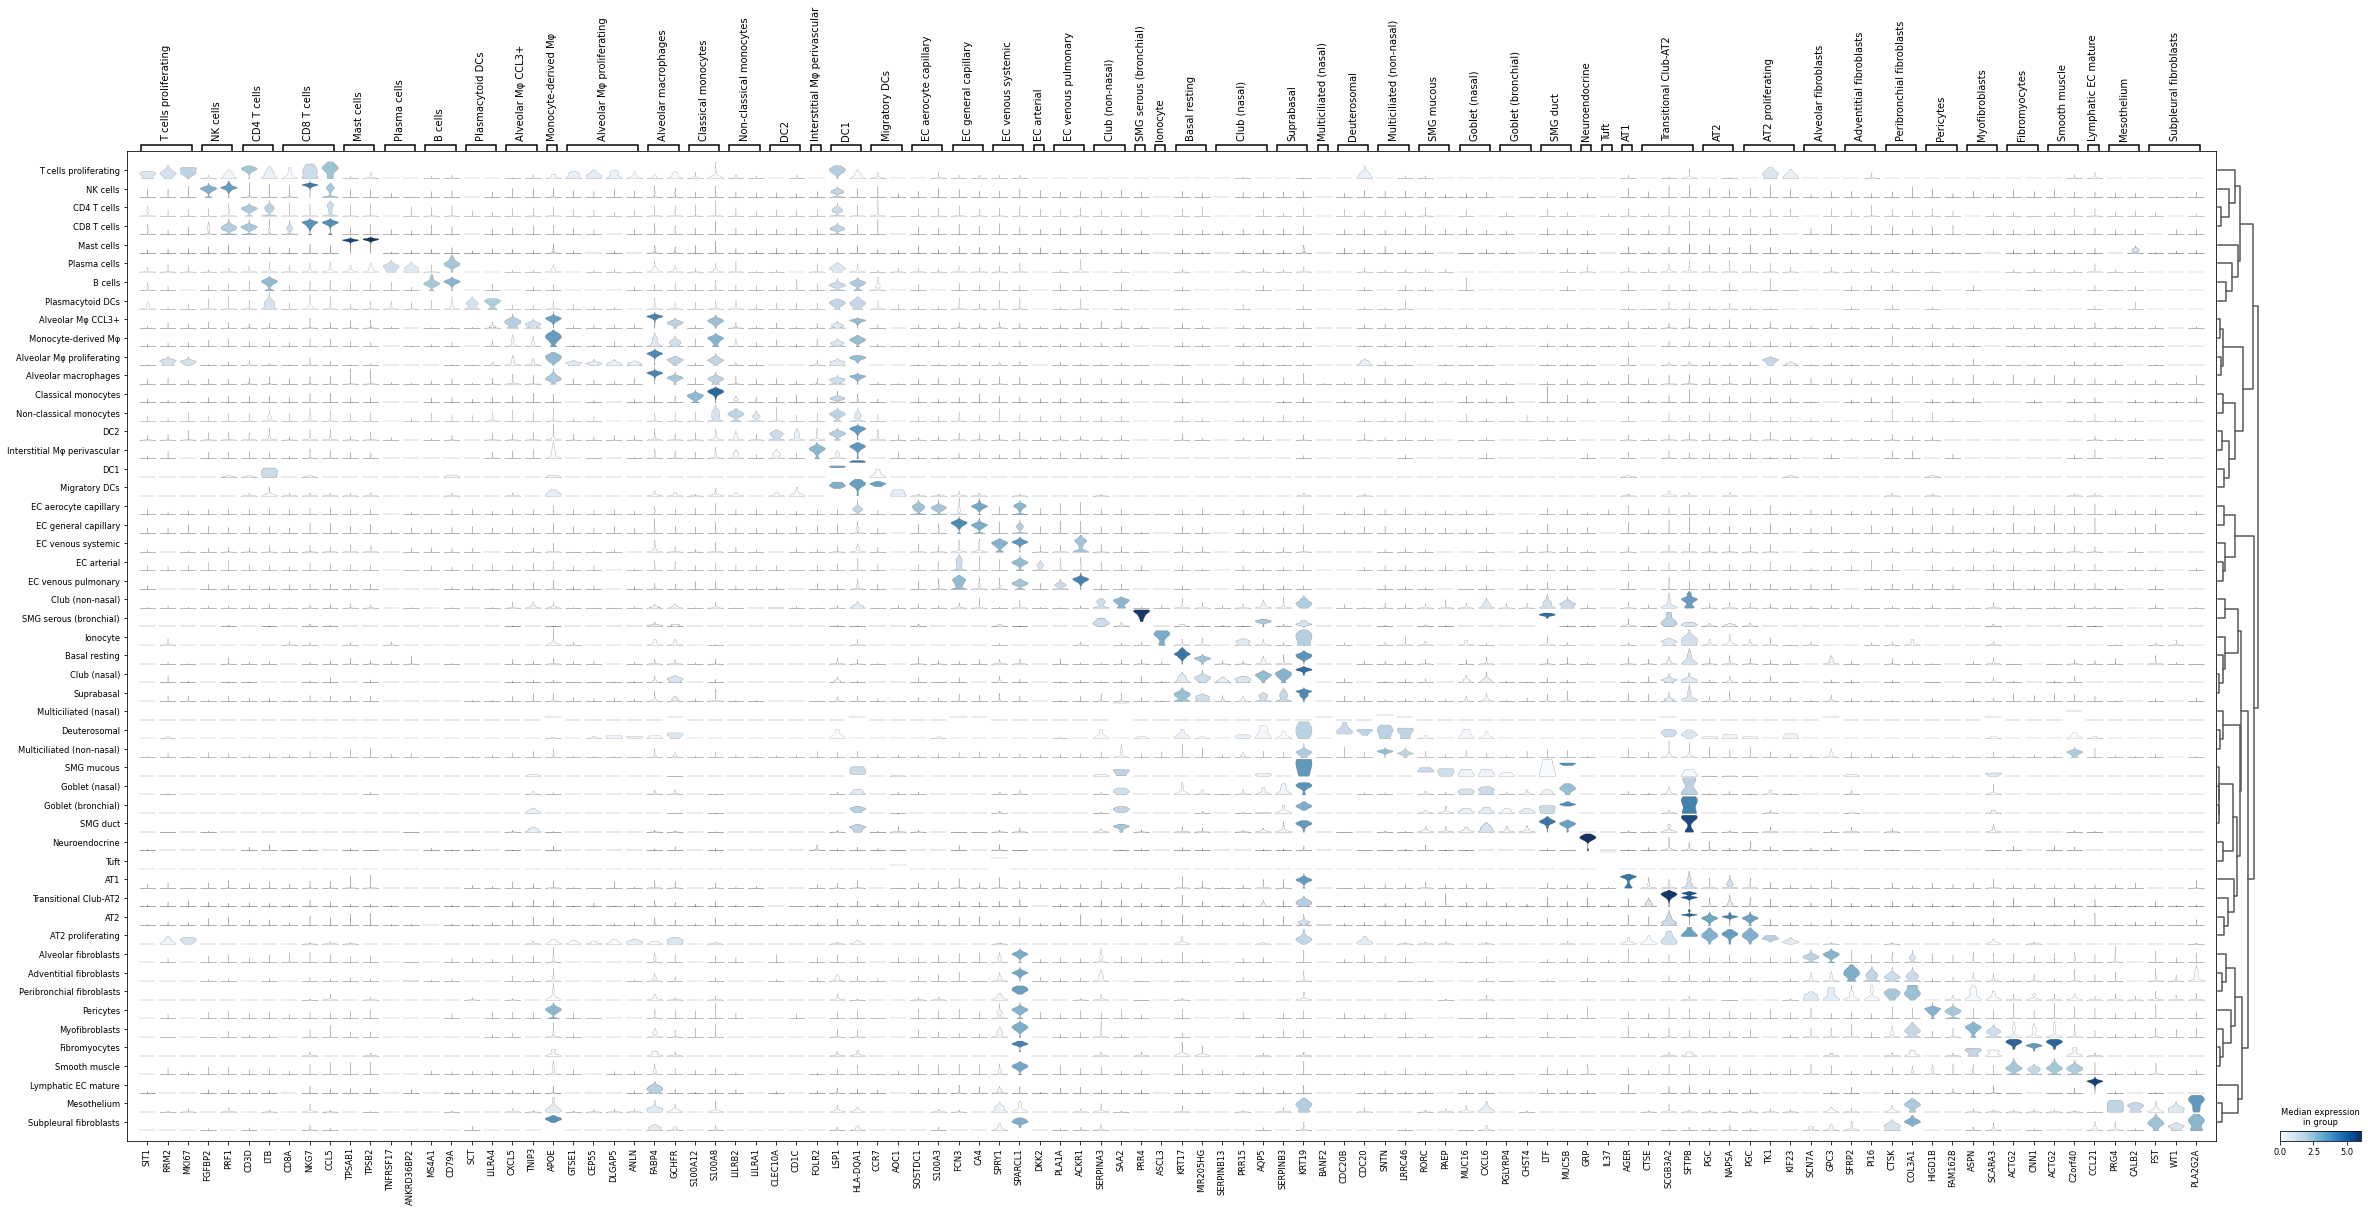

In [19]:
ALGORITHMICALLY_DERIVED_MARKERS[ANNOTATION_COLUMN_NAME] = dict(
    zip(
        ns_forest_markers_df['clusterName'], 
        ns_forest_markers_df['NSForest_markers']
    )
)

sc.pl.stacked_violin(
    predictions_adata, 
    var_names=ALGORITHMICALLY_DERIVED_MARKERS[ANNOTATION_COLUMN_NAME], 
    groupby=ANNOTATION_COLUMN_NAME, 
    dendrogram=True, 
    use_raw=False
)

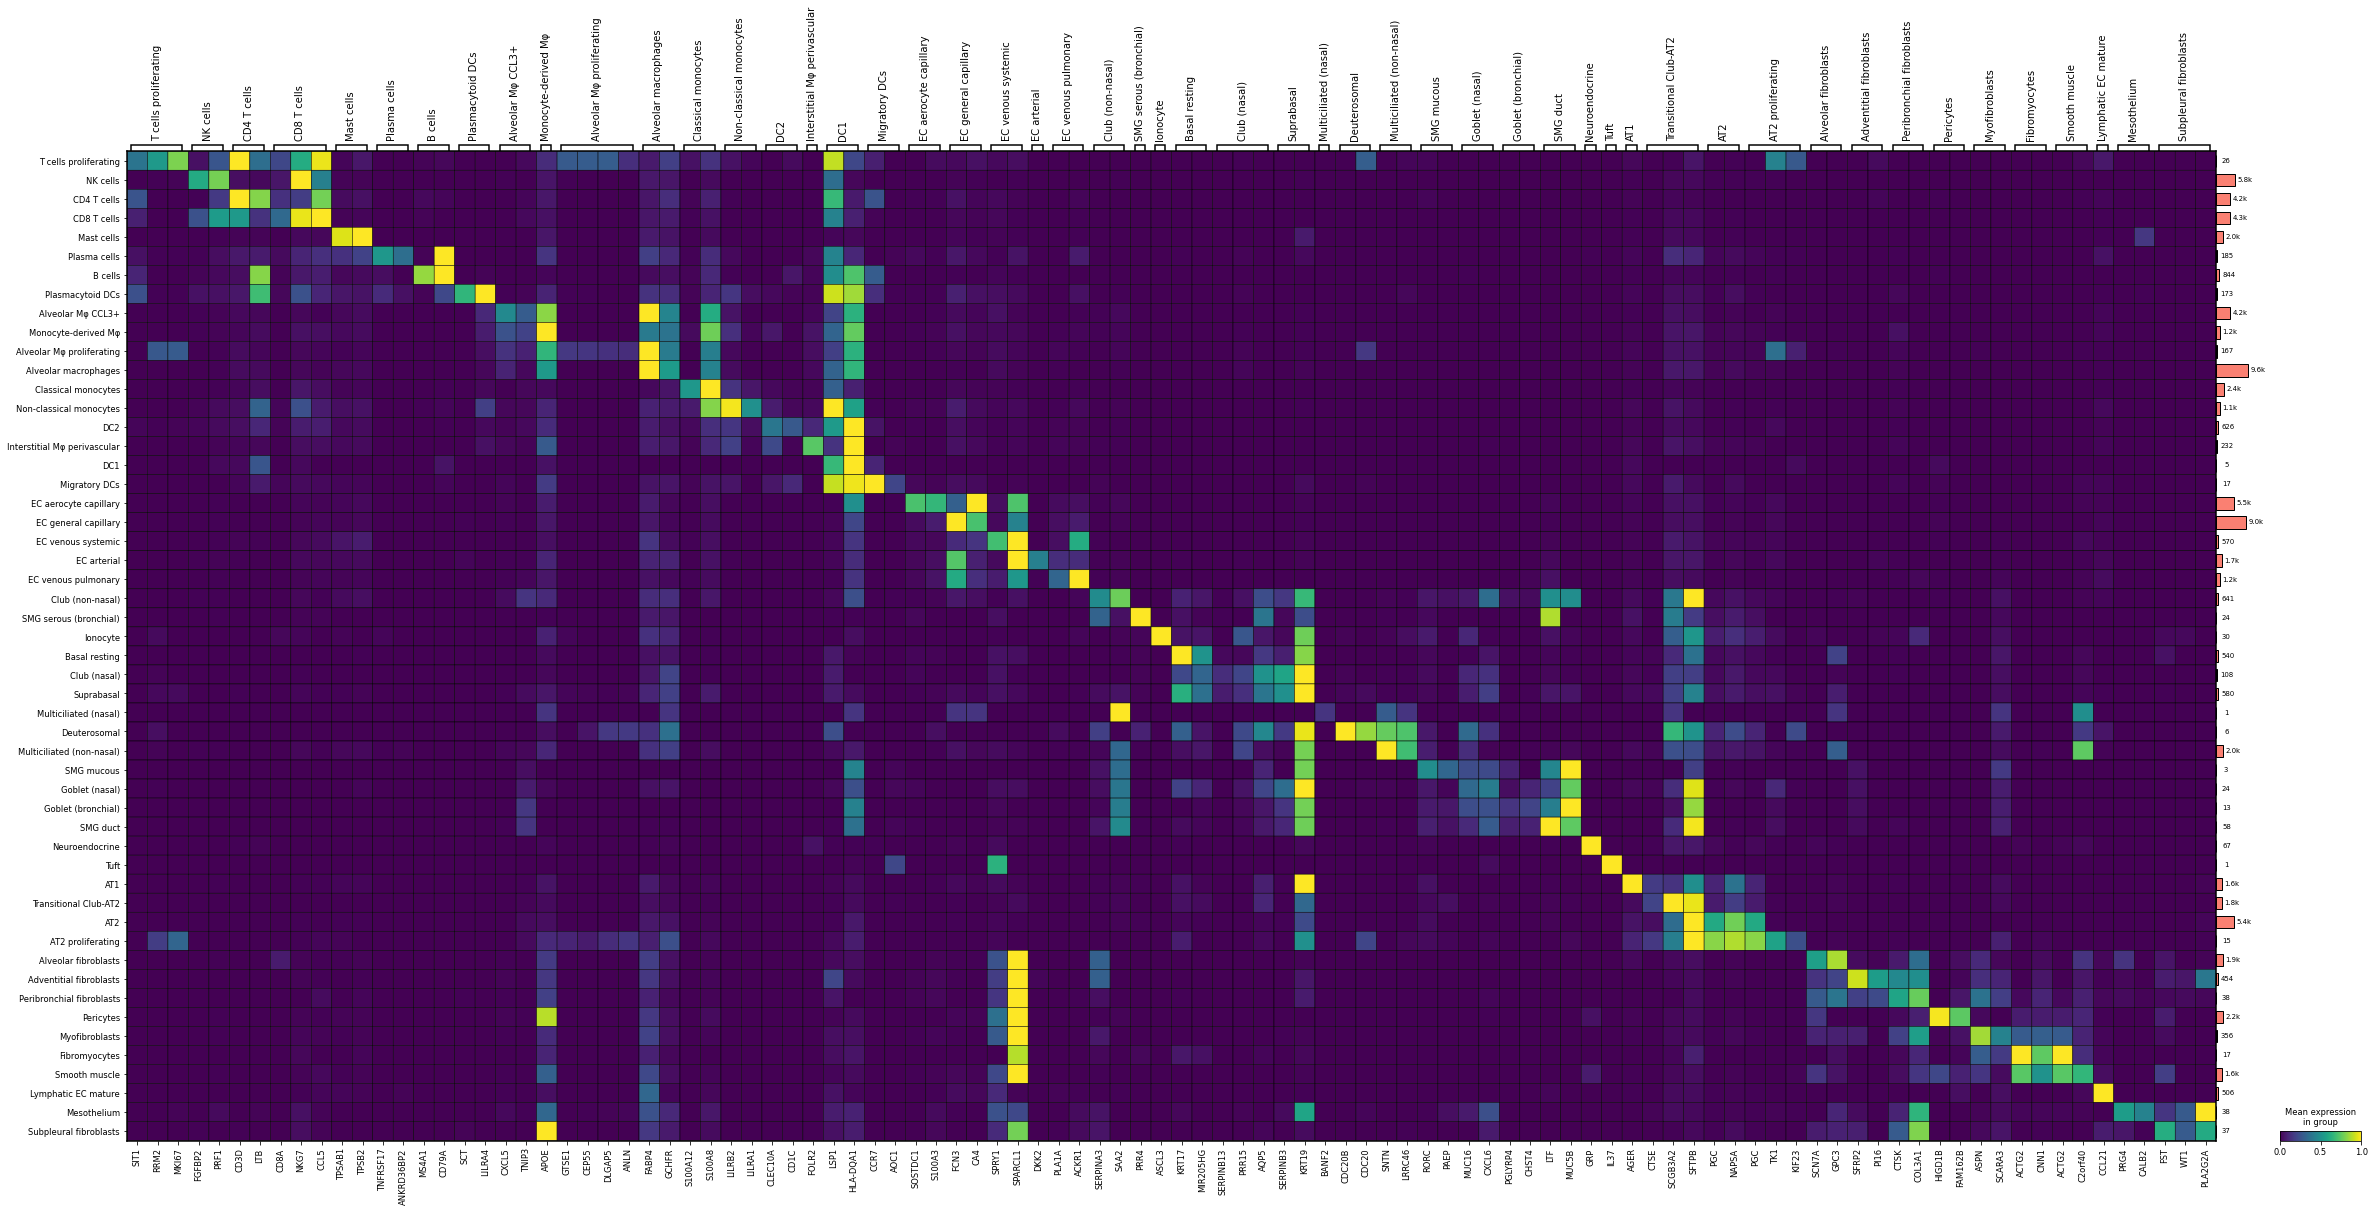

In [20]:
fig = sc.pl.matrixplot(
    predictions_adata, 
    var_names=ALGORITHMICALLY_DERIVED_MARKERS[ANNOTATION_COLUMN_NAME], 
    groupby=ANNOTATION_COLUMN_NAME, 
    dendrogram=True, 
    return_fig=True, 
    standard_scale='group')
fig.add_totals().style(edge_color='black', edge_lw=0.5)
fig.show()

## b. Now, onto CellTypist annotations and corresponding NSForest markers:

In [21]:
from ns_forest.NSForest_v3dot9_1 import NSForest
from ast import literal_eval
import os

# Which column of CT-annotations do you want to analyze?
ANNOTATION_SOURCE_NAME = 'celltypist'
ANNOTATION_COLUMN_NAME = f'{ANNOTATION_SOURCE_NAME}_preds'

ns_forest_markers_filename = f'{ANNDATA_FOLDER}/{QUERY_DATASET_NAME}/NSForest_{ANNOTATION_SOURCE_NAME}_markers.csv'
print(f'Checking if NS-Forest has already been executed...')
try:
    ns_forest_markers_df = pd.read_csv(ns_forest_markers_filename)
    if ns_forest_markers_df['NSForest_markers'].dtype == 'object':
        ns_forest_markers_df.loc[:, 'NSForest_markers'] = [literal_eval(s) for s in ns_forest_markers_df['NSForest_markers'].values]
    print(f'Found pre-computed NS-Forest markers at {ns_forest_markers_filename}...')
except Exception as e:
    print(f'Something went wrong while trying to read {ns_forest_markers_filename}. Are you sure it exists? {e}')
    print(f'Running NSForest over entire AnnData containing {predictions_adata.obs[ANNOTATION_COLUMN_NAME].nunique()} labels...')
    ns_forest_markers_df = NSForest( 
        adata=predictions_adata,  cluster_header=ANNOTATION_COLUMN_NAME,
        # n_trees = 10, n_genes_eval = 10,  cluster_list = ["AT2"]
    )
    ns_forest_markers_df.to_csv(ns_forest_markers_filename, index=False)
    
    
ns_forest_markers_df.head()

Checking if NS-Forest has already been executed...
Found pre-computed NS-Forest markers at Datasets/LCA/NSForest_celltypist_markers.csv...


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


clusterName   f_score       PPV     TN   FP    FN    TP  \
0                      AT1  0.865108  0.943574  73626   54   488   903   
1                      AT2  0.947963  0.974979  69565  118   790  4598   
2        AT2 proliferating  0.984848  1.000000  75057    0     1    13   
3  Adventitial fibroblasts  0.817522  0.976667  74472    7   299   293   
4        Alveolar Mφ CCL3+  0.847982  0.937550  69162  232  2194  3483   

   marker_count   NSForest_markers  \
0             1             [AGER]   
1             2      [PGC, SFTPA1]   
2             3  [PRC1, PGC, HMMR]   
3             2    [SFRP2, IGFBP6]   
4             2     [CXCL5, TNIP3]   

                                        binary_genes  
0  ['AGER', 'SCEL', 'TNNC1', 'RTKN2', 'UPK3B', 'C...  
1  ['ABCA3', 'LRRK2', 'LAMP3', 'PGC', 'PLA2G1B', ...  
2  ['YBX2', 'SFN', 'KIF23', 'PRC1', 'PGC', 'HMMR'...  
3  ['SFRP2', 'MFAP5', 'SFRP4', 'PI16', 'PDGFRL', ...  
4  ['TNFAIP6', 'CXCL5', 'TNIP3', 'IL1B', 'ITGB8',...

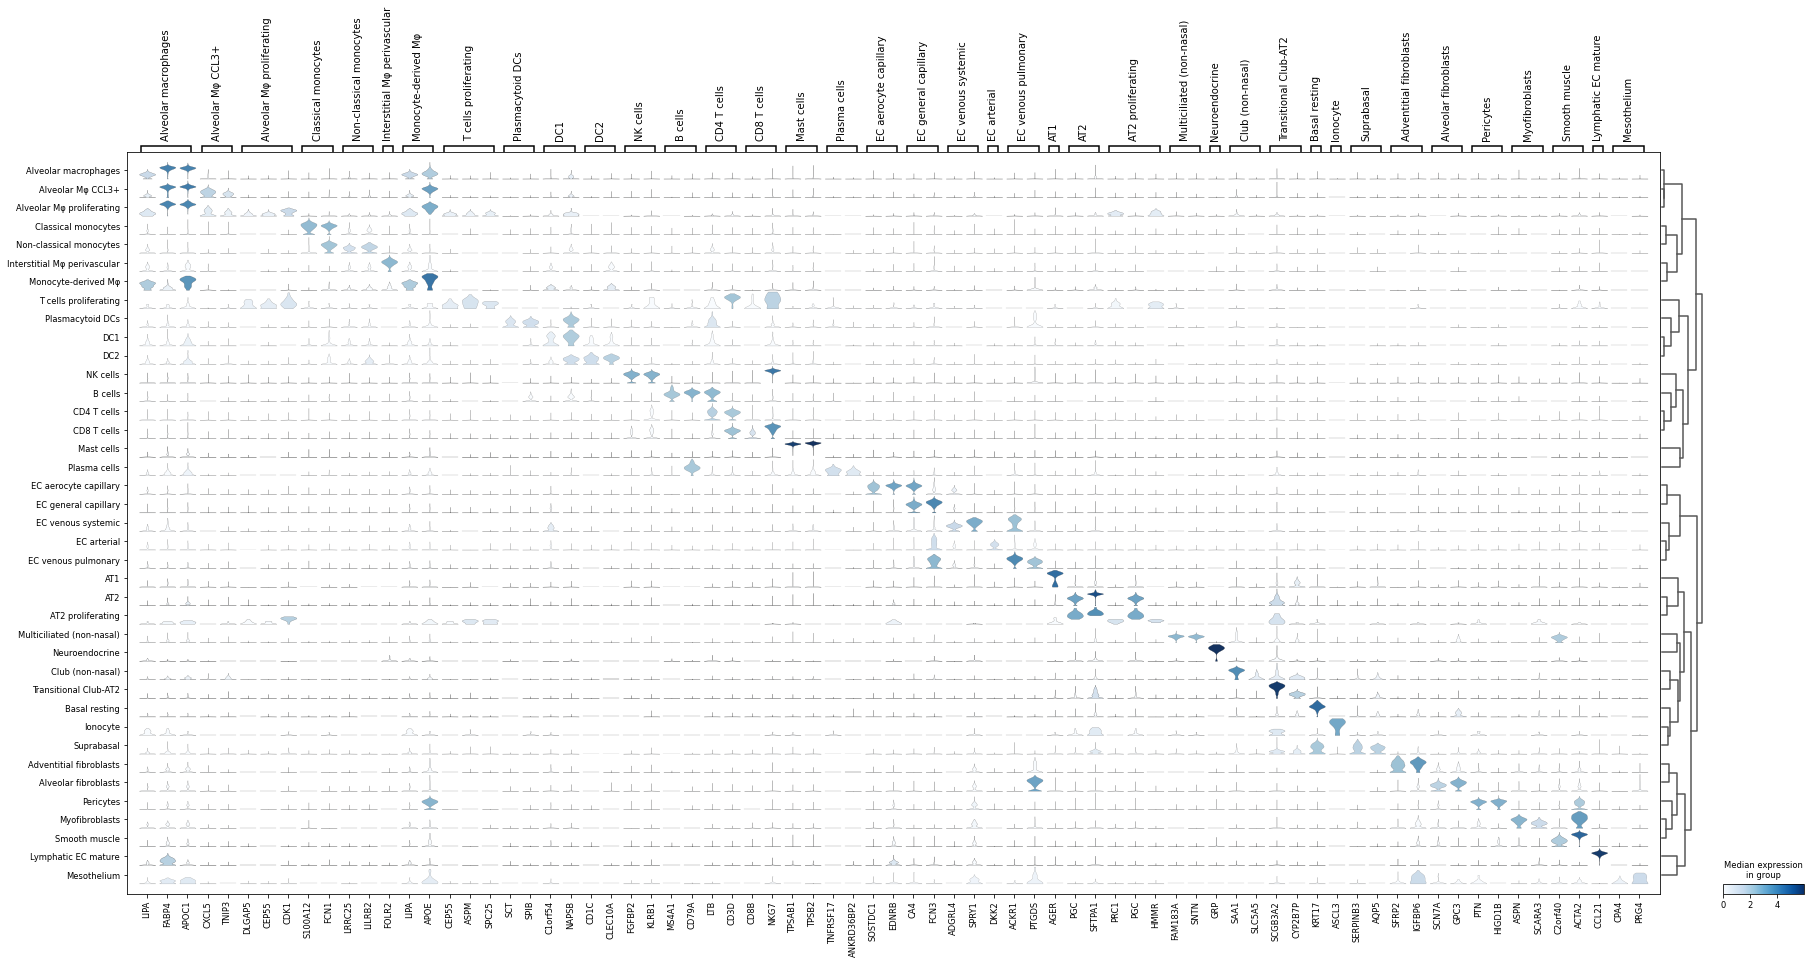

In [22]:
ALGORITHMICALLY_DERIVED_MARKERS[ANNOTATION_COLUMN_NAME] = dict(
    zip(
        ns_forest_markers_df['clusterName'], 
        ns_forest_markers_df['NSForest_markers']
    )
)

sc.pl.stacked_violin(
    predictions_adata, 
    var_names=ALGORITHMICALLY_DERIVED_MARKERS[ANNOTATION_COLUMN_NAME], 
    groupby=ANNOTATION_COLUMN_NAME, 
    dendrogram=True, 
    use_raw=False
)

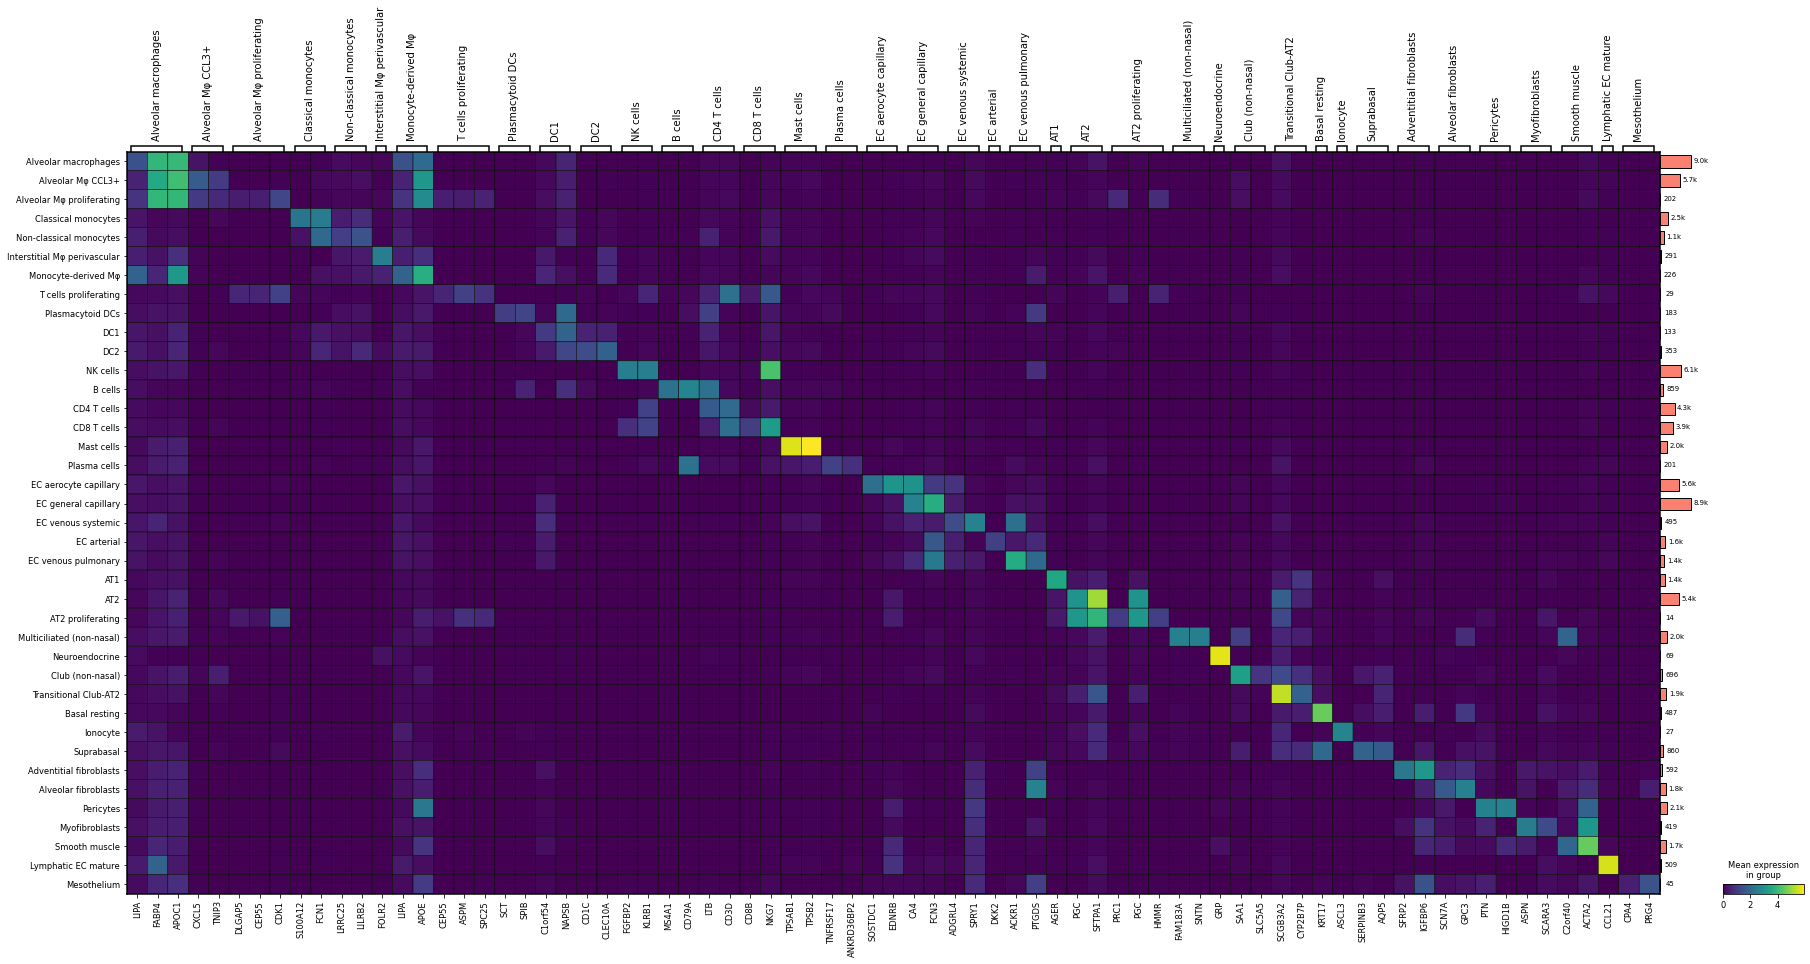

In [23]:
fig = sc.pl.matrixplot(
    predictions_adata, 
    var_names=ALGORITHMICALLY_DERIVED_MARKERS[ANNOTATION_COLUMN_NAME], 
    groupby=ANNOTATION_COLUMN_NAME, 
    dendrogram=True, 
    return_fig=True
)
fig.add_totals().style(edge_color='black', edge_lw=0.5)
fig.show()

## c. Next, onto PopV annotations and corresponding NSForest markers:

(33 hours on Vikrant's local machine)

In [24]:
from ns_forest.NSForest_v3dot9_1 import NSForest
from ast import literal_eval
import os

# Which column of CT-annotations do you want to analyze?
ANNOTATION_SOURCE_NAME = 'popv'
ANNOTATION_COLUMN_NAME = f'{ANNOTATION_SOURCE_NAME}_preds'

ns_forest_markers_filename = f'{ANNDATA_FOLDER}/{QUERY_DATASET_NAME}/NSForest_{ANNOTATION_SOURCE_NAME}_markers.csv'
print(f'Checking if NS-Forest has already been executed...')
try:
    ns_forest_markers_df = pd.read_csv(ns_forest_markers_filename)
    if ns_forest_markers_df['NSForest_markers'].dtype == 'object':
        ns_forest_markers_df.loc[:, 'NSForest_markers'] = [literal_eval(s) for s in ns_forest_markers_df['NSForest_markers'].values]
    print(f'Found pre-computed NS-Forest markers at {ns_forest_markers_filename}...')
except Exception as e:
    print(f'Something went wrong while trying to read {ns_forest_markers_filename}. Are you sure it exists? {e}')
    print(f'Running NSForest over entire AnnData containing {predictions_adata.obs[ANNOTATION_COLUMN_NAME].nunique()} labels...')
    ns_forest_markers_df = NSForest( 
        adata=predictions_adata,  cluster_header=ANNOTATION_COLUMN_NAME,
        # n_trees = 10, n_genes_eval = 10,  cluster_list = ["AT2"]
    )
    ns_forest_markers_df.to_csv(ns_forest_markers_filename, index=False)
    
    
ns_forest_markers_df.head()

Checking if NS-Forest has already been executed...
Found pre-computed NS-Forest markers at Datasets/LCA/NSForest_popv_markers.csv...


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


clusterName   f_score       PPV     TN    FP    FN  \
0                           B cell  0.294295  0.316045  73804   422   650   
1  CD4-positive, alpha-beta T cell  0.146251  0.132571  64787  6373  2937   
2  CD8-positive, alpha-beta T cell  0.224395  0.282176  68276  1623  4534   
3                 adventitial cell  0.055659  0.060000  74372   282   399   
4                       basal cell  0.181438  0.163453  72011  1909   778   

    TP  marker_count              NSForest_markers  \
0  195             4    [CCL20, CXCL5, IL1B, KYNU]   
1  974             3  [HLA-DQA2, TYROBP, HLA-DPB1]   
2  638             2                [HLA-E, ITM2B]   
3   18             3           [TUBB, SRGN, RPS26]   
4  373             3          [CCL5, NKG7, RPS4Y1]   

                                        binary_genes  
0  ['TNFAIP6', 'TNIP3', 'CCL20', 'CXCL5', 'IL1B',...  
1  ['HLA-DQA2', 'HLA-DRB6', 'TYROBP', 'HLA-DPA1',...  
2  ['HLA-DPA1', 'HLA-E', 'ITM2B', 'HLA-C', 'B2M',...  
3         ['IFI27', 'TUBB', 'SRGN', 'RPS26', 'PFN1']  
4  ['CCL5', 'PTPRCAP', 'NKG7', 'GZMB', 'CMC1', 'R...

categories: B cell, CD4-positive, alpha-beta T cell, CD8-positive, alpha-beta T cell, etc.
var_group_labels: B cell, CD4-positive, alpha-beta T cell, CD8-positive, alpha-beta T cell, etc.


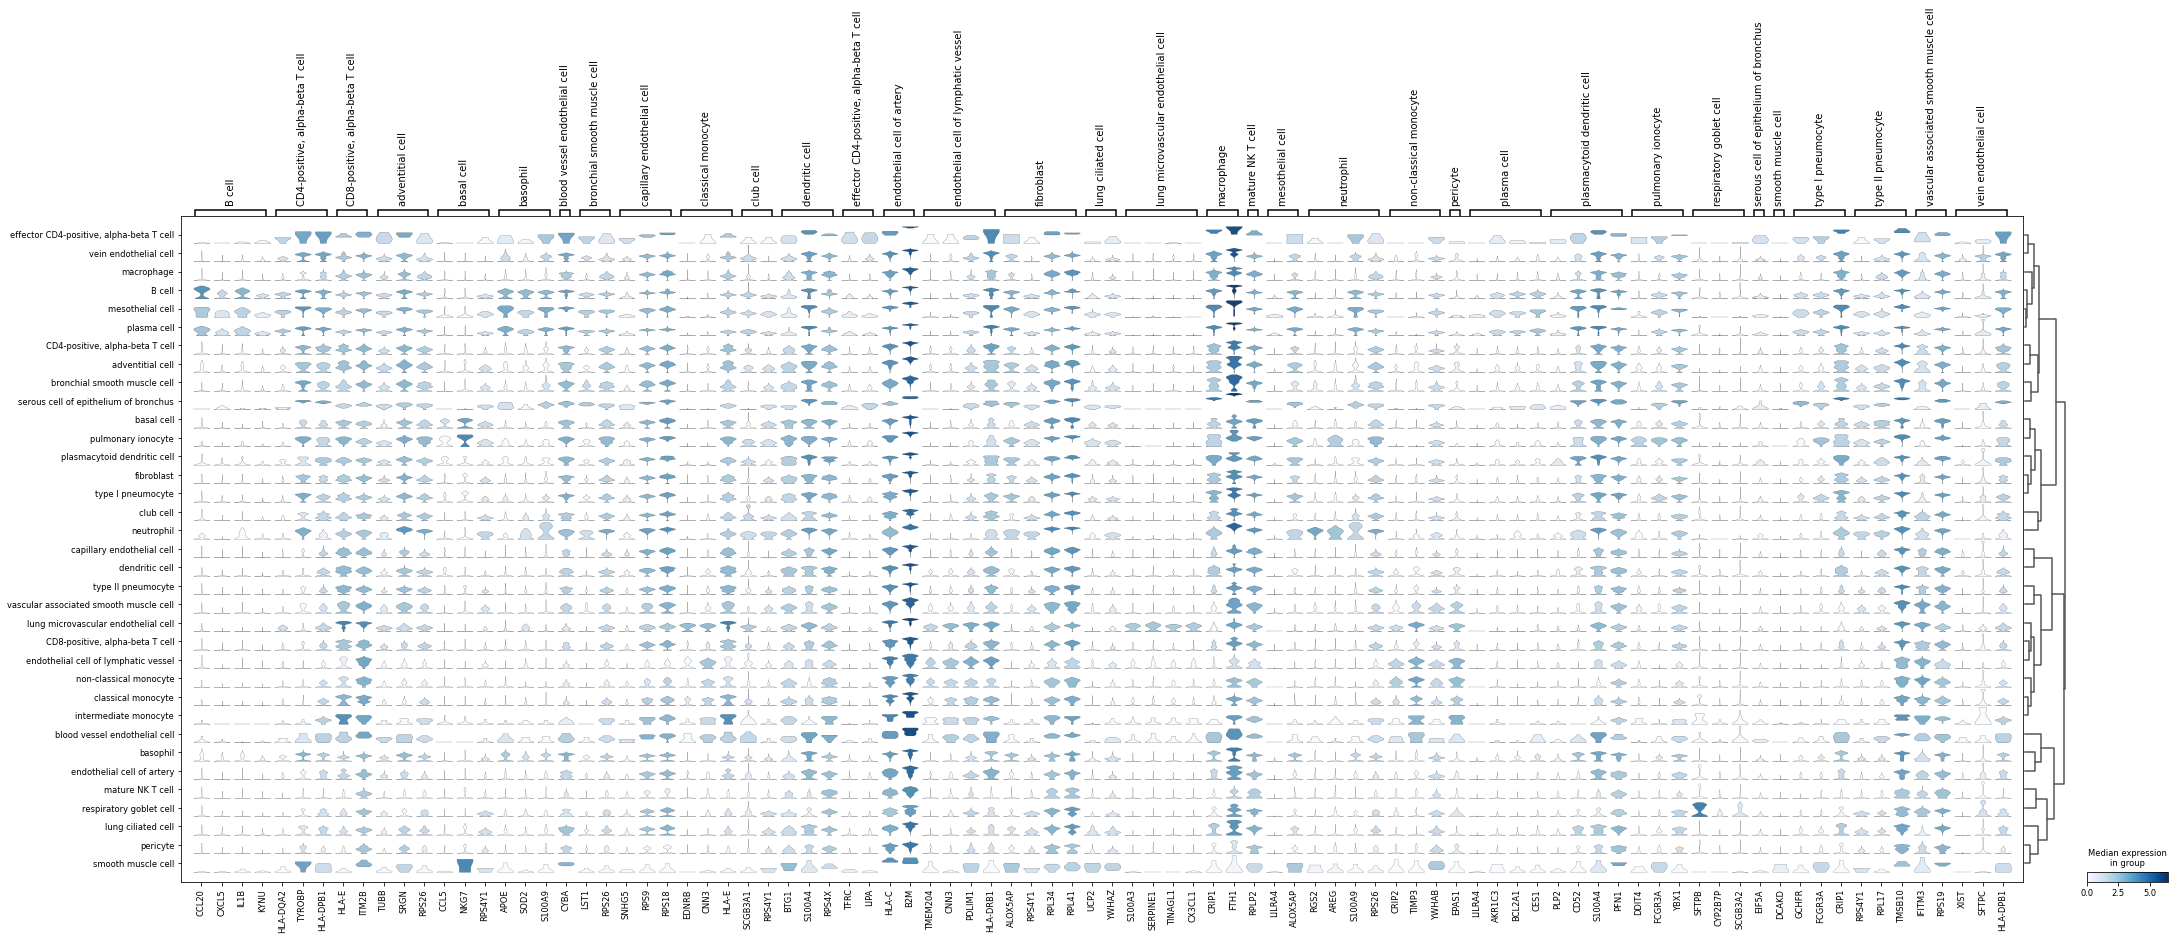

In [25]:
ALGORITHMICALLY_DERIVED_MARKERS[ANNOTATION_COLUMN_NAME] = dict(
    zip(
        ns_forest_markers_df['clusterName'], 
        ns_forest_markers_df['NSForest_markers']
    )
)

sc.pl.stacked_violin(
    predictions_adata, 
    var_names=ALGORITHMICALLY_DERIVED_MARKERS[ANNOTATION_COLUMN_NAME], 
    groupby=ANNOTATION_COLUMN_NAME, 
    dendrogram=True, 
    use_raw=False
)

categories: B cell, CD4-positive, alpha-beta T cell, CD8-positive, alpha-beta T cell, etc.
var_group_labels: B cell, CD4-positive, alpha-beta T cell, CD8-positive, alpha-beta T cell, etc.


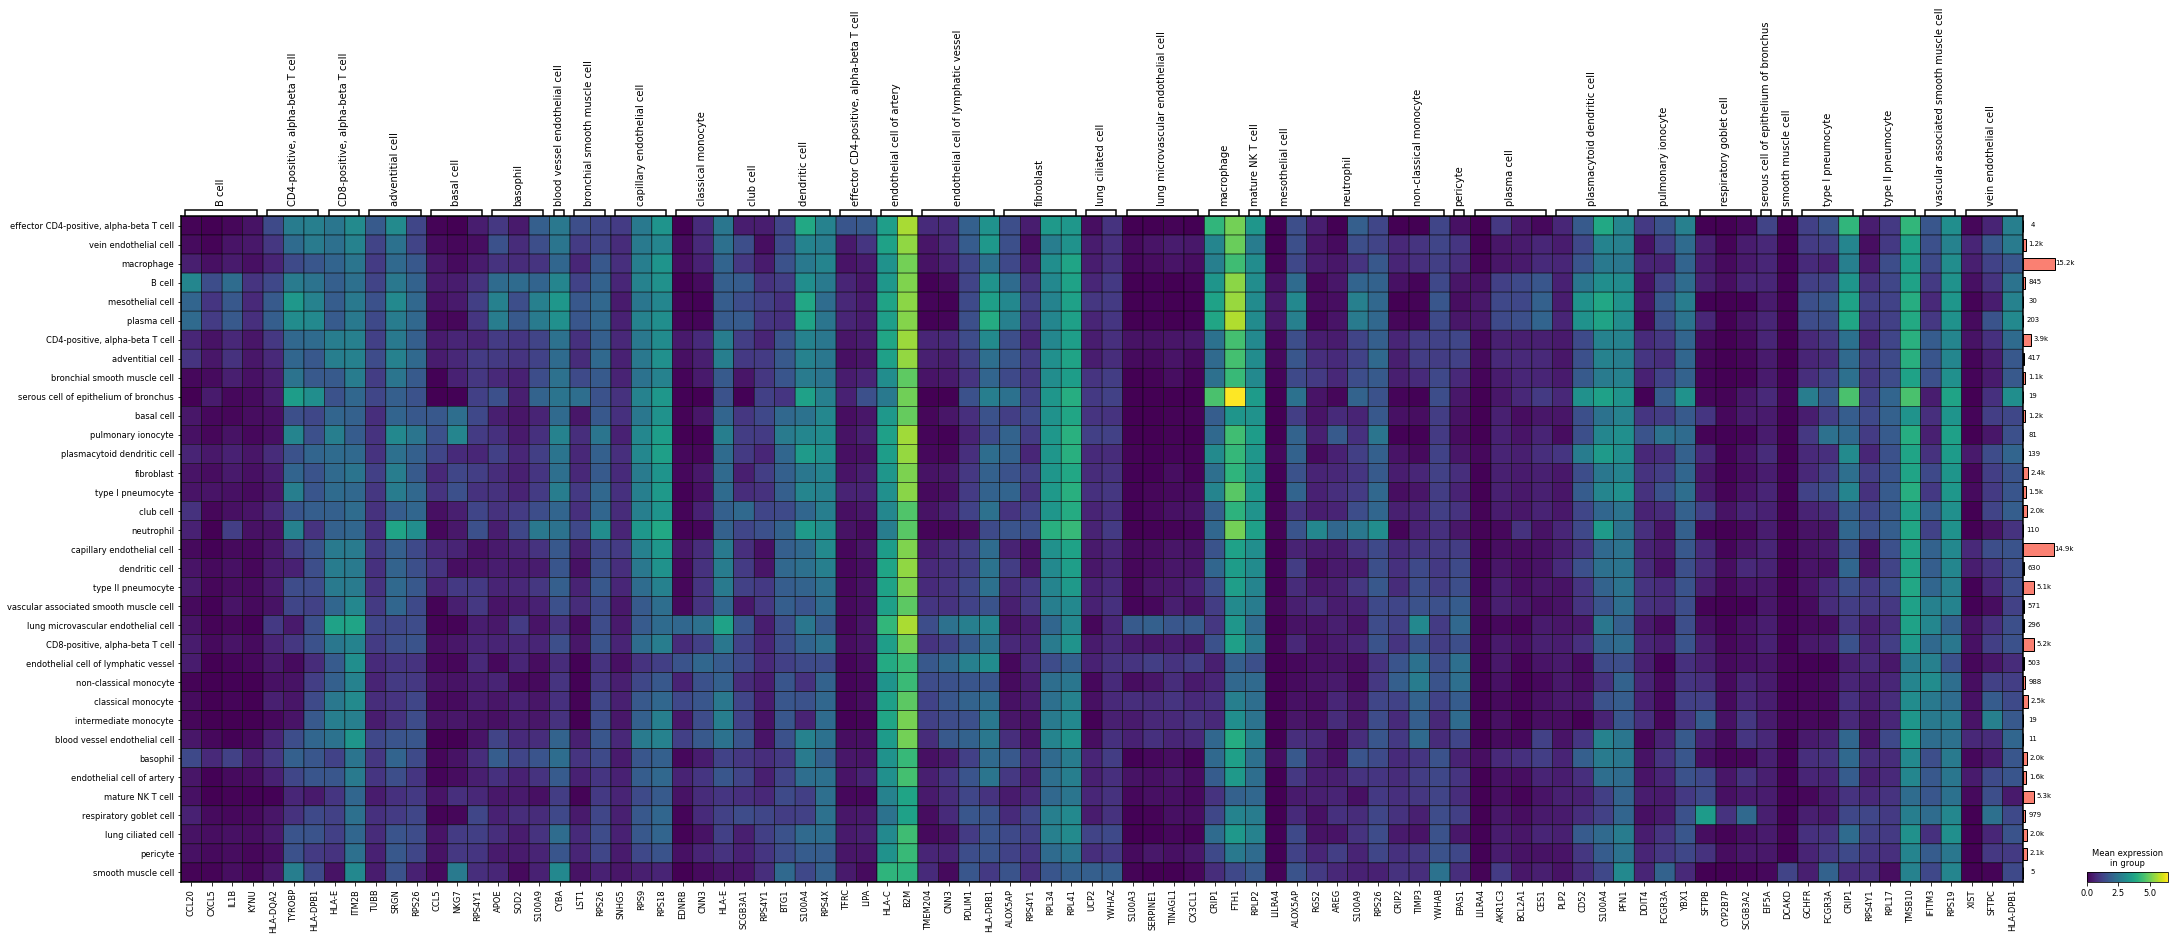

In [26]:
fig = sc.pl.matrixplot(
    predictions_adata, 
    var_names=ALGORITHMICALLY_DERIVED_MARKERS[ANNOTATION_COLUMN_NAME], 
    groupby=ANNOTATION_COLUMN_NAME, 
    dendrogram=True, 
    return_fig=True
)
fig.add_totals().style(edge_color='black', edge_lw=0.5)
fig.show()

### Merging the crosswalk information into the anndata object as well as markers identified so far.

In [27]:
import numpy as np



def merge_asctb_crosswalk_into_derived_markers(translation_hmap, markers_dict, annotation_colnames=['azimuth_preds'], verbose=False):
    """Uses a translation hashmap of the final-crosswalk, and adds a copy of nsforest derived-markers but with ASCT+B naming convention.
    For ex- 
    ```python
        {
            {'azimuth_preds': {'at2' : [list of markers]}, ...},
            ...
        }
    ```
    copies over to
    ```python
        {
            {'azimuth_preds': {'at2' : [list of markers]}, ...},
            {'azimuth_preds_asctb_equivalent': {'proliferating at2 ' : [list of markers]}, ...},
            ...
        }
    ```

    Args:
        translation_hmap (dict): Contains the final-crosswalk translations: `[unique_cts, asctb_equivalent]`.
        markers_dict (dict): Json-structure of `{ source : { celltype : list(markers) } }`.
        annotation_colnames (list, optional): Original list of keys in the `algorithmically_derived_markers`. Defaults to `['azimuth_preds']`.
        verbose (bool, optional): Flag to indicate logging in verbose mode. Defaults to False.

    Returns:
        dict: Json-structure of `{ source : { celltype : list(markers) } }`, similar to `algorithmically_derived_markers` including new asctb-equivalent-keys.
    """
    # Let's create a dictionary copy of all 3 predictions-and-markers, but with predictions translated to ASCTB naming conventions
    for colname in annotation_colnames:
        new_annotation_colname = f'{colname}_asctb_equivalent'
        if verbose:  print(f'Creating a new {new_annotation_colname} dictionary of nsforest-markers...')
        asctb_equivalent_markers_dict = {}
        for ctlabel, markers in markers_dict[colname].items():
            ctlabel = ctlabel.lower().replace('φ','ï†')
            ctlabel_asctb_equivalent = translation_hmap[ctlabel].lower().replace('φ','ï†')
            if verbose:  print(ctlabel, ctlabel_asctb_equivalent, markers)
            asctb_equivalent_markers_dict[ctlabel_asctb_equivalent] = markers
        markers_dict[new_annotation_colname] = asctb_equivalent_markers_dict

    if verbose:  print(markers_dict.keys())
    return markers_dict






ANNOTATION_COLNAMES = ['azimuth_preds', 'celltypist_preds', 'popv_preds']
ALGORITHMICALLY_DERIVED_MARKERS = merge_asctb_crosswalk_into_derived_markers(
    translation_hmap=translation_hmap,
    markers_dict=ALGORITHMICALLY_DERIVED_MARKERS,
    annotation_colnames=ANNOTATION_COLNAMES,
    verbose=False
)


CANONICAL_MARKERS = merge_asctb_crosswalk_into_derived_markers(
    translation_hmap=translation_hmap,
    markers_dict=CANONICAL_MARKERS,
    annotation_colnames=['azimuth'],
    verbose=False
)

# Merge the crosswalk into the AnnData.obs dataframe
for colname in ANNOTATION_COLNAMES:
    new_colname = colname + '_asctb_equivalent'
    predictions_adata.obs[new_colname] = predictions_adata.obs[colname].apply(lambda x : translation_hmap[x.lower().replace('φ','ï†')])



print(f'Markers now available for: {ALGORITHMICALLY_DERIVED_MARKERS.keys()}')
print(f'Annotation columns available in the AnnData now are: {[c for c in list(predictions_adata.obs.columns) if "preds" in c]}')
agg_crosswalk_markers_df.head()

Markers now available for: dict_keys(['azimuth_preds', 'celltypist_preds', 'popv_preds', 'azimuth_preds_asctb_equivalent', 'celltypist_preds_asctb_equivalent', 'popv_preds_asctb_equivalent'])
Annotation columns available in the AnnData now are: ['popv_preds', 'celltypist_preds', 'azimuth_preds', 'azimuth_preds_asctb_equivalent', 'celltypist_preds_asctb_equivalent', 'popv_preds_asctb_equivalent']


unique_cts  azimuth_count  popv_count  celltypist_count  \
0      adventitial cell            0.0       417.0               0.0   
1            suprabasal          580.0         0.0             860.0   
2  alveolar fibroblasts         1942.0         0.0            1847.0   
3  alveolar macrophages         9565.0         0.0            9004.0   
4    alveolar mï† ccl3+            0.0         0.0               0.0   

             asctb_equivalent  \
0             suprabasal cell   
1             suprabasal cell   
2  alveolar type 1 fibroblast   
3         alveolar macrophage   
4   alveolar macrophage ccl3+   

                                     asctb_markers  \
0                [NOTCH3, KRT19, NGFR, TP63, KRT5]   
1                [NOTCH3, KRT19, NGFR, TP63, KRT5]   
2                     [PCDH15, WNT2, TCF21, PLIN2]   
3   [CD68, MARCO, CD11c, CD45, MRC1, FABP4, CD163]   
4  [PTPRC/CD45, CD68, CD45, SIGLEC1, CCL3, CD206 ]   

                                     azimuth_markers  
0                                                NaN  
1  [TACSTD2, PRDX2, SFN, KRT19, SERPINB4, KLK11, ...  
2  [COL6A1, LUM, C1R, COL1A2, A2M, GPX3, MFAP4, A...  
3  [LAPTM5, C1QC, HLA-DPA1, FCER1G, ACP5, COTL1, ...  
4                                                NaN

# Create aggregated CxG per CT to identify top k Gene-expressions

# Plot the top k gene-expressions for each Cell-Type, Algorithm

> `Azimuth Preds` - 51xk plots

> `CellTypist Preds` - 34xk plots

> `PopV Preds` - 40xk plots

Suitable use-case for a [Raincloud-Plot](https://www.kaggle.com/code/carlmcbrideellis/box-strip-violin-raincloud-plot)?

todo/done:

1. Adjust x-axis labels on each figure-subaxis: gene-name not visible! - ✅

2. Add main title as `Azimuth Preds`, `CellTypist Preds`, and `PopV Preds` - ✅

3. Filter out the CT-prediction subset dataframes having <5 cells - ✅


!pip install -q ptitprince

In [ ]:
# !pip install -q ptitprince

# Let's investigate agreeability per cluster between [`topK`, `bottomK`] genes (by median), [`Azimuth`/`ASCTB`] canonical genes, and [`NSForest`] derived genes.

In [ ]:
import ptitprince as pt, matplotlib.pyplot as plt


def get_aggregated_cellbygene_matrix(adata, celltype_labels_column='azimuth_preds', aggregation_method='mean', verbose=False):
    """Ensures a standardized CxG matrix in the input AnnData.
    Performs required CxG aggregations by grouping for each Cell-Type label.

    Args:
        adata (Scanpy.AnnData): Input AnnData containing a valid CxG matrix as 'X', and annotations in the 'obs' dataframe.
        celltype_labels_column (str, optional): Column containing annotations in the 'obs' dataframe. Defaults to 'azimuth_preds'.
        aggregation_method (str, optional): `mean/median/count`. Defaults to 'mean'.
        verbose (bool, optional): Flag to indicate logging in verbose mode. Defaults to False.
    
    Returns:
        pd.DataFrame: Aggregated CxG dataframe containing each Cell-Type label mapped to `mean/median/count` values of all gene-expressions.
    """
    adata.X = adata.to_df()

    celltype_labels = adata.obs[celltype_labels_column]
    if verbose:  print(f'celltype_labels are: {celltype_labels}')

    cxg_df = pd.DataFrame(adata.X, index=adata.obs_names, columns=adata.var_names)
    if verbose:  print(f'new_cxg_df has columns: {cxg_df.columns}')

    cxg_annotated_df = pd.concat([cxg_df, celltype_labels], axis=1)
    if verbose:  print(f'Aggregation based on: {aggregation_method}')

    agg_cxg_df = cxg_annotated_df.groupby(by=[celltype_labels_column], as_index=False).agg(aggregation_method)
    if verbose:  print(agg_cxg_df.head())

    return agg_cxg_df



def get_top_and_bottom_K_genes(agg_cxg_df, celltype_labels_column='azimuth_preds', top_k=10, bottom_k=0, verbose=False):
    """Filters the aggregated CxG dataframe to retrieve the top-K Cell-Type labels showing highest `mean/median/count` gene-expressions.

    The `agg_cxg_df` dataframe should contain columns: [`celltype_labels_column`, `gene1_val`, `gene2_val`, ...] 
    ____ where `gene1_val`, `gene2_val`, ... indicate aggregated expression values for that celltype-label.

    Args:
        agg_cxg_df (pd.DataFrame): Aggregated CxG dataframe containing each Cell-Type label mapped to `mean/median/count` values of all gene-expressions.
        celltype_labels_column (str, optional): Column containing annotations in the 'obs' dataframe. Defaults to 'azimuth_preds'.
        top_k (int, optional): Top k genes to retrieve. Defaults to 10.
        bottom_k (int, optional): Bottom k genes to retrieve. Defaults to 0.
        verbose (bool, optional): Flag to indicate logging in verbose mode. Defaults to False.

    Returns:
        dict: A dictionary containing `{'CT-label' : { 'index':[top-K genes] ,  'values':[top-K gene-expression values] }  }`
    """
    agg_cxg_T_df = agg_cxg_df.set_index(celltype_labels_column).T
    ct_labels = agg_cxg_T_df.columns.values.tolist()
    most_expressed_genes_dict = {}
    for ct_label in ct_labels:
        most_expressed_genes = agg_cxg_T_df.loc[agg_cxg_T_df[ct_label]>0, ct_label].sort_values(ascending=False)

        if verbose:  print(f'Fetching top-{top_k} genes expressed by `{ct_label}`...')
        top_k_expressed_genes = most_expressed_genes.head(n=top_k).reset_index()
        if verbose:  print(f'\ntop_most_expressed_genes={top_k_expressed_genes}')

        if verbose:  print(f'Fetching bottom-{bottom_k} genes expressed by `{ct_label}`...')
        bottom_k_expressed_genes = most_expressed_genes.tail(n=bottom_k).reset_index()
        if verbose:  print(f'\n\nbottom_most_expressed_genes={bottom_k_expressed_genes}')
        
        most_expressed_genes_dict[ct_label] = pd.concat([top_k_expressed_genes, bottom_k_expressed_genes], axis=0).to_dict(orient='list')
    return most_expressed_genes_dict





def create_rainplot_top_k_genes(adata, most_expressed_genes, celltype_labels_column='azimuth_preds', aggregation_method='mean', filter_sparse_cell_types=False, verbose=False):
    """Filters out the sparse Cell-Type clusters with <5 cells. These would not give much info in the RainCloud plot.
    
    For each unique and valid Cell-Type label cluster, make a Raincloud plot for the top-K gene-expressions in a row.

    Args:
        adata (Scanpy.AnnData): Input AnnData containing a valid CxG matrix as 'X', and annotations in the 'obs' dataframe.
        celltype_labels_column (str, optional): Column containing annotations in the 'obs' dataframe. Defaults to 'azimuth_preds'.
        aggregation_method (str, optional): `mean/median/mode/count`. Defaults to 'mean'.
        filter_sparse_cell_types (bool, optional): Flag to indicate if . Defaults to False.
        verbose (bool, optional): Flag to indicate logging in verbose mode. Defaults to False.
    """
    
    if filter_sparse_cell_types:
        non_sparse_cell_types = adata.obs[celltype_labels_column].value_counts()>=5
        fig, ax = plt.subplots(figsize=(50,80), nrows=non_sparse_cell_types[non_sparse_cell_types==True].count())
        ordered_cell_types = reversed(sorted(non_sparse_cell_types[non_sparse_cell_types==True].index))
    else:
        fig, ax = plt.subplots(figsize=(50,80), nrows=len(adata.obs[celltype_labels_column].unique()))
        ordered_cell_types = reversed(sorted(adata.obs[celltype_labels_column].unique()))
        
    if verbose:  print(ordered_cell_types)

    for i, ct_label in enumerate(ordered_cell_types):
        if verbose:  print('Fetching the CxG subset-dataframe for current CT-annotation and top K gene-expressions: CTxK')
        ct_most_exp_gene_distributions = adata[adata.obs[celltype_labels_column]==ct_label, most_expressed_genes[ct_label]['index']].X
        ct_most_exp_gene_distributions = pd.DataFrame(ct_most_exp_gene_distributions, columns=most_expressed_genes[ct_label]['index'])
        if verbose:  print(f'ct_label[{i}]={ct_label} has shape: {ct_most_exp_gene_distributions.shape}...')

        if filter_sparse_cell_types and ct_most_exp_gene_distributions.shape[0]<5:
            if verbose:  print(f'ct_label={ct_label} observed in <5 cells. Skipping its Raincloud plot...')
            fig.delaxes(ax[i])
            continue

        order = pd.DataFrame(ct_most_exp_gene_distributions.agg(aggregation_method), columns=[f'{aggregation_method}_expression'])
        order = order.sort_values(by=[f'{aggregation_method}_expression'], ascending=[False]).index
        
        ax[i] = pt.RainCloud(
            ax=ax[i], 
            data=ct_most_exp_gene_distributions,
            palette='crest' if i%2==0 else 'flare',
            point_size=1,       # cloud point-size
            bw=0.05,            # bandwidth-param for Kernel-Density-Estimation plot
            cut=0,              # cut-param for Kernel-Density-Estimation plot
            orient='v',
            width_viol=1,
            pointplot=True,     # Line connecting the means across the RainCloud plots
            linecolor='grey' if i%2==0 else 'orange',
            order=list(order)
        )
        ax[i].set_ylabel(ct_label.replace(' ','\n'))
        labels = ax[i].set_xticklabels(labels=list(order), rotation=0, fontsize=8)
        for i, label in enumerate(labels):
            label.set_y(label.get_position()[1]*0.0001)
    
    fig_title = f'Top-{TOP_K}{f" and Bottom-{BOTTOM_K}" if BOTTOM_K else ""} {AGGREGATION_METHOD} gene-expressions per CT-annotation from {CELLTYPE_LABELS_COLUMN.replace("_preds","").capitalize()}'
    fig.suptitle(
        t=fig_title,
        x=.5, 
        y=.9, 
        verticalalignment='top', 
        size=50
    )
    return fig






TOP_K = 100
BOTTOM_K = 0
AGGREGATION_METHOD = 'median'

CELLTYPE_LABELS_COLUMNS = [c for c in list(predictions_adata.obs.columns) if "preds" in c]
MOST_EXPRESSED_GENES = {}
RAINCLOUD_PLOT_FIGURES = {}

for CELLTYPE_LABELS_COLUMN in CELLTYPE_LABELS_COLUMNS:
    print('Each data-source rainplot takes around 8mins, please be patient! Grab a coffee.')
    
    print(f'Creating aggregated cxg matrix for {CELLTYPE_LABELS_COLUMN}.')
    agg_cxg_df = get_aggregated_cellbygene_matrix(predictions_adata, celltype_labels_column=CELLTYPE_LABELS_COLUMN, aggregation_method=AGGREGATION_METHOD, verbose=False)

    print(f'Fetching top-{TOP_K} and bottom-{BOTTOM_K} genes for {CELLTYPE_LABELS_COLUMN}.')
    MOST_EXPRESSED_GENES[CELLTYPE_LABELS_COLUMN] = get_top_and_bottom_K_genes(agg_cxg_df, celltype_labels_column=CELLTYPE_LABELS_COLUMN, top_k=TOP_K, bottom_k=BOTTOM_K, verbose=False)

    print(f'Creating raincloud plots for top-{TOP_K} and bottom-{BOTTOM_K} genes for {CELLTYPE_LABELS_COLUMN}.')
    RAINCLOUD_PLOT_FIGURES[CELLTYPE_LABELS_COLUMN] = create_rainplot_top_k_genes(
        predictions_adata,
        most_expressed_genes=MOST_EXPRESSED_GENES[CELLTYPE_LABELS_COLUMN],
        celltype_labels_column=CELLTYPE_LABELS_COLUMN,
        aggregation_method=AGGREGATION_METHOD,
        filter_sparse_cell_types=False,
        verbose=False
    )

# Visualizing the mean expression values for top-K Genes via a heatmap

## We'll overlay the features-selected via NSForest, with Canonical Marker-features from Azimuth/ASCTB

#### Azimuth and CellTypist Lung Naming convention is just completely different as compared to PopV and ASCTB.

Impact- even though we've parsed the ASCT+B data to fetch a key-value store of `CT -> Markers`, we can't overlay this information onto the top-K gene-medians plot.

Solution- Use the crosswalk translation table to bring the naming convention to a controlled vocabulary.

!pip install -i https://test.pypi.org/simple/ asctb-ct-label-mapper

!pip install matplotlib-venn

Something went wrong with the Venn-diagram creation...[Errno 2] No such file or directory: 'data/threeway_intersection_Annotation labels from the 3 reference-models are disjointed sets.png'


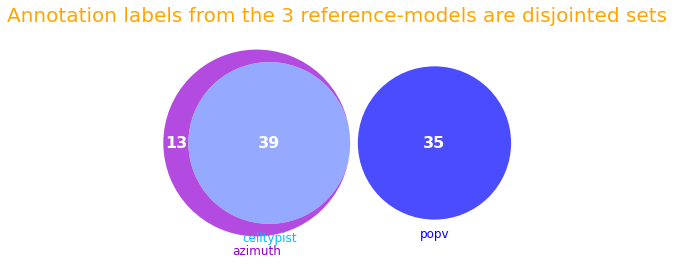

In [29]:
from asctb_ct_label_mapper.utilities.plotting import make_venn_diagram

try:
    make_venn_diagram(
        A=set(predictions_adata.obs['azimuth_preds'].values), 
        B=set(predictions_adata.obs['celltypist_preds'].values), 
        C=set(predictions_adata.obs['popv_preds'].values), 
        labels=['azimuth', 'celltypist', 'popv'],
        title='Annotation labels from the 3 reference-models are disjointed sets'
    )
except Exception as e:
    print(f'Something went wrong with the Venn-diagram creation...{e}')

Something went wrong with the Venn-diagram creation...[Errno 2] No such file or directory: 'data/threeway_intersection_Crosswalked-Annotation labels from the 3 reference-models for better agreeability.png'


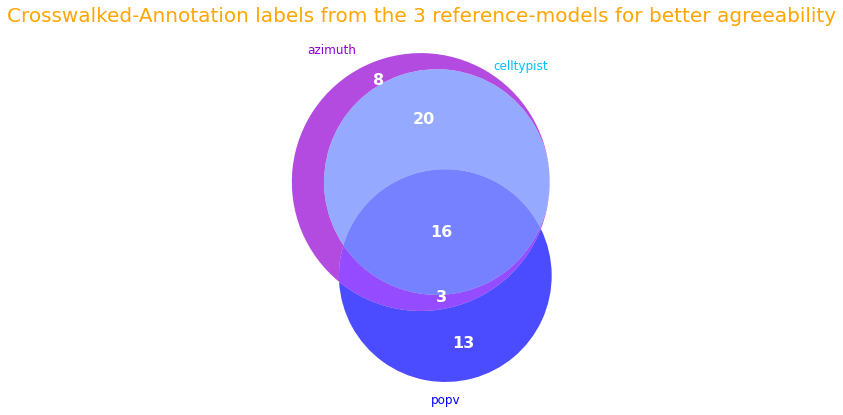

In [30]:
from asctb_ct_label_mapper.utilities.plotting import make_venn_diagram

try:
    make_venn_diagram(
        A=set(predictions_adata.obs['azimuth_preds_asctb_equivalent'].values), 
        B=set(predictions_adata.obs['celltypist_preds_asctb_equivalent'].values), 
        C=set(predictions_adata.obs['popv_preds_asctb_equivalent'].values), 
        labels=['azimuth', 'celltypist', 'popv'],
        title='Crosswalked-Annotation labels from the 3 reference-models for better agreeability'
    )
except Exception as e:
    print(f'Something went wrong with the Venn-diagram creation...{e}')

### Let's overlay the ASCT+B markers onto the Top-K gene-medians for Azimuth predictions

In [ ]:
import numpy as np
import plotly.graph_objects as go


def create_agreeability_matrix(most_expressed_genes, canonical_markers, derived_markers, agreeability_map, verbose=True):
    """Creates a matrix of the MxK (Cell by Gene) subset with a character-value in each cell to indicate overlayed results of multiple sources.
    The character in each cell will be defined by the `agreeability_map` variable. For ex- 
    ```python
        {
            'both_matching' : '✖',
            'derived_marker' : 'Đ',
            'canonical_marker' : 'Ȼ'
        }
    ```

    Args:
        most_expressed_genes (dict): A dictionary containing `{'CT-label' : { 'index':[top-K genes] ,  'values':[top-K gene-expression values] }  }`
        canonical_markers (dict): A dictionary containing `{'CT-label' : [top-K genes]}` fetched from a reliable source. ex- Azimuth maintains top-10 canonical markers per CT.
        derived_markers (dict): A dictionary containing `{'CT-label' : [top-K genes]}` fetched algorithmically. ex- NSForest performs feature selection per CT-cluster.
        agreeability_map (dict): A dictionary to indicate what character to use for which scenario.
        verbose (bool, optional): Flag to indicate logging in verbose mode. Defaults to False.

    Returns:
        list, list: List of gene-names, and List/Matrix of agreeability indicators.
    """
    gene_names = []
    agreeability_indicators = []
    
    for celltype, top_k_genes in most_expressed_genes.items():
        celltype = celltype.lower().replace('φ','ï†')
        gene_names.append(top_k_genes['index'])
        agreeability_indicators_celltype = ['' for _ in top_k_genes['index']]
        for i, gene in enumerate(top_k_genes['index']):
            if celltype not in derived_markers and celltype not in canonical_markers:
                if verbose:  print(f'{celltype} not found in derived_markers nor canonical_markers')
                break
            if gene in derived_markers.get(celltype,[]) and gene in canonical_markers.get(celltype,[]):
                agreeability_indicators_celltype[i] = agreeability_map['both_matching']
            elif gene in derived_markers.get(celltype,[]):
                agreeability_indicators_celltype[i] = agreeability_map['derived_marker']
            elif gene in canonical_markers.get(celltype,[]):
                agreeability_indicators_celltype[i] = agreeability_map['canonical_marker']
        agreeability_indicators.append(agreeability_indicators_celltype)
    return gene_names, agreeability_indicators



def create_heatmap_top_k_genes(most_expressed_genes, canonical_markers_one, canonical_markers_two, derived_markers, top_k=10, bottom_k=0, verbose=False):
    """Creates a dataframe containing CT-Label, Aggregated-Gene-expression-value (CxG).
    Plots a heatmap for this aggregated view generated from the input dictionary.

    Args:
        most_expressed_genes (dict): A dictionary containing `{'CT-label' : { 'index':[top-K genes] ,  'values':[top-K gene-expression values] }  }`
        canonical_markers (dict): A dictionary containing `{'CT-label' : [top-K genes]}` fetched from a reliable source. ex- Azimuth maintains top-10 canonical markers per CT.
        derived_markers (dict): A dictionary containing `{'CT-label' : [top-K genes]}` fetched algorithmically. ex- NSForest performs feature selection per CT-cluster.
        top_k (int, optional): Top k genes to retrieve. Defaults to 10.
        bottom_k (int, optional): Bottom k genes to retrieve. Defaults to 0.
        verbose (bool, optional): Flag to indicate logging in verbose mode. Defaults to False.

    Returns:
        plt.Figure
    """
    k_colnames = [f'top marker #{i}' for i in range(1,top_k+1)] + [f'bottom marker #{i}' for i in range(1,bottom_k+1)]
    df = pd.DataFrame(columns=['celltype_labels_column'] + k_colnames)
    df['celltype_labels_column'] = most_expressed_genes.keys()

    for ct_label, gene_exp_dict in most_expressed_genes.items():
        df.loc[df['celltype_labels_column']==ct_label, k_colnames] = gene_exp_dict[ct_label][:top_k+bottom_k]
    df = df.set_index('celltype_labels_column').astype(np.float64)

    # Populate the gene-names for top-k gene expressions (used on hover)
    # Populate the agreeability-indicator marks to indicate if current gene-name is also in canonical marker-list and also in algorithmically derived markers
    canonical_markers_one = {ct.lower().replace('φ','ï†') : marker_genes for ct, marker_genes in canonical_markers_one.items()}
    canonical_markers_two = {ct.lower().replace('φ','ï†') : marker_genes for ct, marker_genes in canonical_markers_two.items()}
    derived_markers = {ct.lower().replace('φ','ï†') : marker_genes for ct, marker_genes in derived_markers.items()}
    
    agreeability_map = {
        'both_matching' : '✖',
        'derived_marker' : 'Đ',
        'canonical_marker' : 'Ȼ'
    }
    if verbose:  print(f'Creating agreability matrix for first set of canonical markers')
    gene_names_one, agreeability_indicators_one = create_agreeability_matrix(most_expressed_genes, canonical_markers_one, derived_markers, agreeability_map, verbose)
    if verbose:  print(f'Creating agreability matrix for second set of canonical markers')
    gene_names_two, agreeability_indicators_two = create_agreeability_matrix(most_expressed_genes, canonical_markers_two, derived_markers, agreeability_map, verbose)
    
    
    fig = go.Figure()
    
    fig.add_trace(
        go.Heatmap(
            y=df.index.values,
            x=k_colnames,
            z=df.to_numpy(),
            name='Azimuth Canonical markers',
            text=agreeability_indicators_one,
            texttemplate="%{text}",
            textfont={"size":12, 'color':'white'},
            hovertext=gene_names_one,
            hovertemplate=\
                'CellType: %{y}' + \
                    '<br>Gene-%{x}: %{hovertext}' + \
                        f'<br>{AGGREGATION_METHOD.capitalize()}-val: '+'%{z:.2f}',
            colorscale=[[0, 'lightgreen'], [1, 'darkblue']]
        )
    )

    fig.add_trace(
        go.Heatmap(
            y=df.index.values,
            x=k_colnames,
            z=df.to_numpy(),
            name='ASCT+B Canonical markers',
            text=agreeability_indicators_two,
            texttemplate="%{text}",
            textfont={"size":12, 'color':'white'},
            hovertext=gene_names_two,
            hovertemplate=\
                'CellType: %{y}' + \
                    '<br>Gene-%{x}: %{hovertext}' + \
                        f'<br>{AGGREGATION_METHOD.capitalize()}-val: '+'%{z:.2f}',
            colorscale=[[0, 'lightgreen'], [1, 'darkblue']]
        )
    )

    base_title = f'Top-{top_k} and Bottom-{bottom_k} genes' if bottom_k else f'Top-{top_k} genes'
    fig.update_layout(
        width=1800,
        height=1800,
        xaxis={'title':f'{base_title} per CellType Cluster'},
        yaxis={'title':'CellType Label'},
        margin={'t': 200},
        title_text=f'{base_title}-{AGGREGATION_METHOD} values per CellType-cluster ({CELLTYPE_LABELS_COLUMN.split("_")[0].capitalize()}) in {QUERY_DATASET_NAME}\
            <br>{agreeability_map["both_matching"]}: Canonical and algorithmically-derived marker\
                <br>{agreeability_map["canonical_marker"]}: Canonical marker\
                    <br>{agreeability_map["derived_marker"]}: Derived marker using an algorithm (ex- NSForest)'
    )

    fig.update_layout(
        updatemenus=[
            {
                'active': 0,
                'direction': 'down',
                'font': {'size' : 15},
                'pad': {'r': 10, 't': 10},
                'showactive': True,
                'xanchor': 'left',
                'x': .825,
                'y': 1.05,
                'yanchor': 'top',
                'buttons': [
                    {
                        'label' : 'ASCT+B Canonical markers',
                        'method' : 'restyle',
                        'args' : [{"visible": [False, True]}]
                    },
                    {
                        'label' : 'Azimuth Canonical markers',
                        'method' : 'restyle',
                        'args' : [{"visible": [True, False]}]
                    }
                ],
            }
        ]
    )

    fig.show()
    return fig


CELLTYPE_LABELS_COLUMN = 'azimuth_preds_asctb_equivalent'
fig = create_heatmap_top_k_genes(
    most_expressed_genes=MOST_EXPRESSED_GENES[CELLTYPE_LABELS_COLUMN],
    canonical_markers_one=CANONICAL_MARKERS['azimuth_asctb_equivalent'],
    canonical_markers_two=CANONICAL_MARKERS['asctb'],
    derived_markers=ALGORITHMICALLY_DERIVED_MARKERS[CELLTYPE_LABELS_COLUMN],
    top_k=TOP_K
    bottom_k=0
)

In [ ]:
CELLTYPE_LABELS_COLUMN = 'celltypist_preds_asctb_equivalent'
fig = create_heatmap_top_k_genes(
    most_expressed_genes=MOST_EXPRESSED_GENES[CELLTYPE_LABELS_COLUMN],
    canonical_markers_one=CANONICAL_MARKERS['azimuth_asctb_equivalent'],
    canonical_markers_two=CANONICAL_MARKERS['asctb'],
    derived_markers=ALGORITHMICALLY_DERIVED_MARKERS[CELLTYPE_LABELS_COLUMN],
    top_k=TOP_K,
    bottom_k=0
)

> Below, the highly expressed genes for PopV's clusters (translated to ASCTB) don't show much info when overlayed with ASCTB known-markers.

In [ ]:
set(MOST_EXPRESSED_GENES['popv_preds_asctb_equivalent'].keys()) & set(CANONICAL_MARKERS['asctb'].keys()), \
    set(MOST_EXPRESSED_GENES['popv_preds_asctb_equivalent'].keys()) & set(CANONICAL_MARKERS['azimuth_asctb_equivalent'].keys())

In [ ]:
set(MOST_EXPRESSED_GENES['popv_preds_asctb_equivalent']['b cell']['index']) & set(CANONICAL_MARKERS['asctb']['b cell']),\
    set(MOST_EXPRESSED_GENES['popv_preds_asctb_equivalent']['b cell']['index']) , set(CANONICAL_MARKERS['asctb']['b cell'])

In [ ]:
CELLTYPE_LABELS_COLUMN = 'popv_preds_asctb_equivalent'
fig = create_heatmap_top_k_genes(
    most_expressed_genes=MOST_EXPRESSED_GENES[CELLTYPE_LABELS_COLUMN],
    canonical_markers_one=CANONICAL_MARKERS['azimuth_asctb_equivalent'],
    canonical_markers_two=CANONICAL_MARKERS['asctb'],
    derived_markers=ALGORITHMICALLY_DERIVED_MARKERS[CELLTYPE_LABELS_COLUMN],
    top_k=TOP_K,
    bottom_k=0
)